#**Cargando el dataset del ECG**




In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from tqdm import tqdm
import pandas as pd
from IPython.display import display
import csv
import sympy

Cargar el archivo .npz

In [ ]:
with np.load('Dataset_ECG_save.npz') as data:
    # Recuperar los arrays del archivo y reconstruir el diccionario
    Dataset_ECG = {key: data[key] for key in data.keys()}
Dataset_ECG


{'base': array([[570., 568., 563., ..., 521., 527., 530.],
        [531., 531., 529., ..., 502., 506., 510.],
        [513., 514., 515., ..., 508., 517., 521.],
        ...,
        [692., 713., 732., ...,   0.,   0.,   0.],
        [533., 532., 531., ...,   0.,   0.,   0.],
        [540., 539., 537., ...,   0.,   0.,   0.]]),
 'target': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])}

In [ ]:
datos_totales=Dataset_ECG["base"]
datos_totales.shape
#Los 50 primeros son basal

(150, 1000)

##Seleccionando los datos según basal, aguantando la respiración o en movimiento

In [ ]:
#Para separar en tres secciones 
num_secciones = 3
filas_por_seccion = datos_totales.shape[0] // num_secciones
secciones = np.split(datos_totales, num_secciones, axis=0)
#Guardando cada base
base=secciones[0]
respiracion=secciones[1]
post_ejercicio=secciones[2]

In [ ]:
base.shape

(50, 1000)

In [ ]:
respiracion.shape

(50, 1000)

In [ ]:
post_ejercicio.shape

(50, 1000)

##Seleccionar un dato al azar de Reaposo y Graficarlo en el tiempo

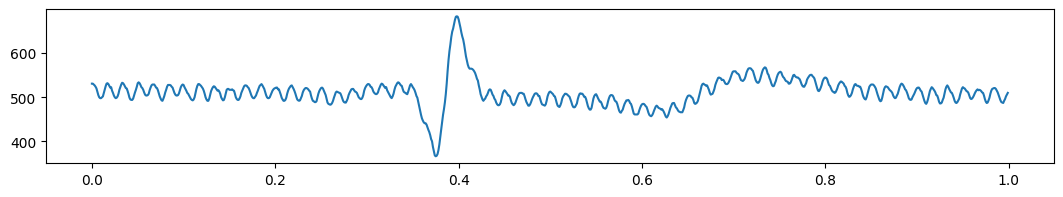

In [ ]:
primer_frame=base[1,:]
#Mostrar datos en el tiempo
#Frecuencia de muestreo del dispositivo de adquisición
Fs = 1000 
Ts=1/Fs
n = np.arange(0,primer_frame.shape[0])  # t = n*Ts ; Ventor de numeros de datos
t = n*Ts #VECTOR TIEMPO 
plt.figure(figsize=(13,2)) #Modificamos el tamaño de la gráfica
plt.plot(t, primer_frame)

#Visualizando toda la Señal para basal en el dominio del Tiempo

Text(0, 0.5, 'mV')

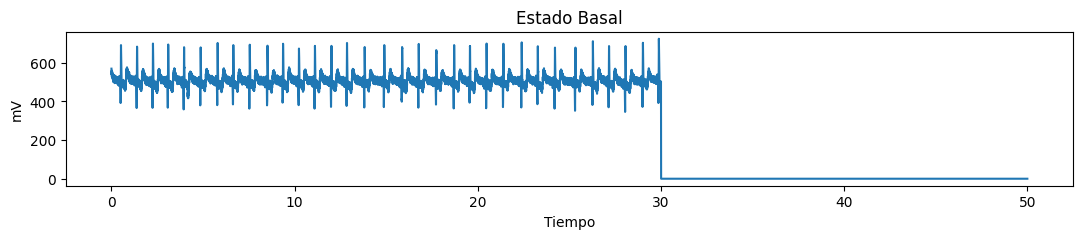

In [ ]:
#Mostrar datos en el tiempo
base_r=np.reshape(base,-1)
#Frecuencia de muestreo del dispositivo de adquisición
Fs = 1000 
Ts=1/Fs
n = np.arange(0,base_r.shape[0])  # t = n*Ts ; Ventor de numeros de datos
t = n*Ts #VECTOR TIEMPO 
plt.figure(figsize=(13,2)) #Modificamos el tamaño de la gráfica
plt.plot(t, base_r)
plt.title("Estado Basal")
plt.xlabel('Tiempo')
plt.ylabel('mV')

###Cortando señal

Text(0, 0.5, 'mV')

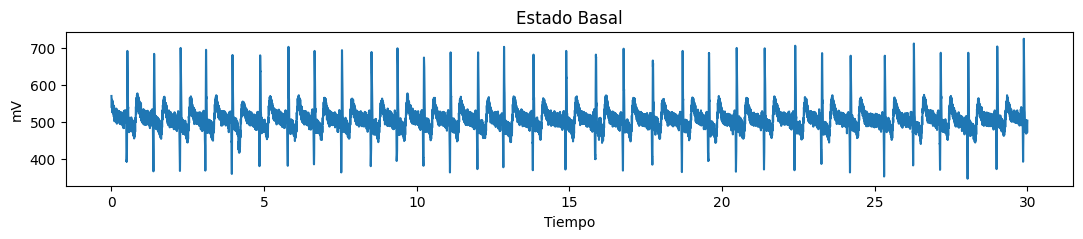

In [ ]:
#DEBIDO A QUE A PARTIR DE SON 3000 DATOS DE LOS 5000
#=base_r[0:30000]
base_total=base_r[np.nonzero(base_r)]

Ts=1/1000
n = np.arange(0,base_total.shape[0])  # t = n*Ts ; Ventor de numeros de datos
t = n*Ts #VECTOR TIEMPO 
plt.figure(figsize=(13,2)) #Modificamos el tamaño de la gráfica
plt.plot(t, base_total)
plt.title("Estado Basal")
plt.xlabel('Tiempo')
plt.ylabel('mV')

##Graficar Su frecuencia 


(1024,)


Text(0, 0.5, '|X|')

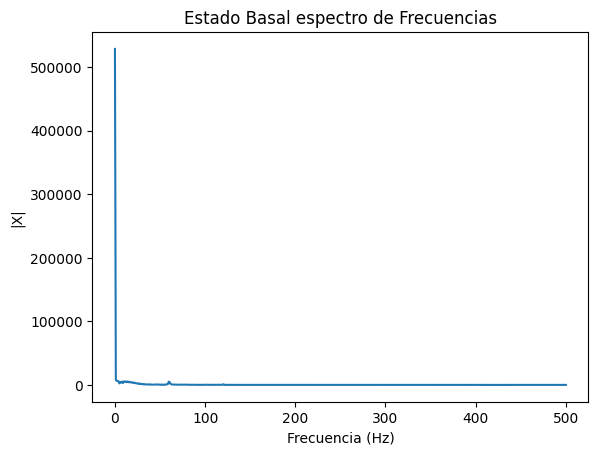

In [ ]:
N = 2**10 #Resolución
fs=1000
base_frec = np.fft.fft(base_total,N)
print(base_frec.shape)
base_frec= base_frec[0:(N//2)]
#magnitud
base_frecm = np.abs(base_frec)
base_frecm = np.round(base_frecm,3)
#frecuencias
F = np.linspace(0, Fs/2, N//2)
#eje de tiempo en seg
t = n/Fs
plt.plot(F,base_frecm)
plt.title("Estado Basal espectro de Frecuencias")
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('|X|')

Se observa un pico muy pronunciado en 0-1 Hz, Por ello se ubicará el grafico después de 1 Hz

(0.0, 1000.0)

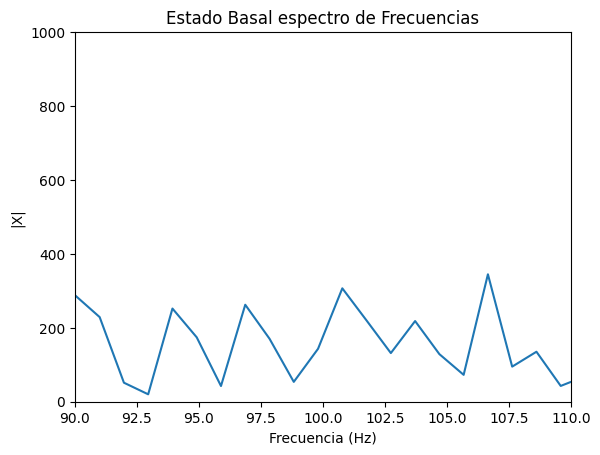

In [ ]:
plt.plot(F,base_frecm)
plt.title("Estado Basal espectro de Frecuencias")
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('|X|')
plt.xlim(90,110)
plt.ylim(0,1000)


#Analisis de Frecuencias
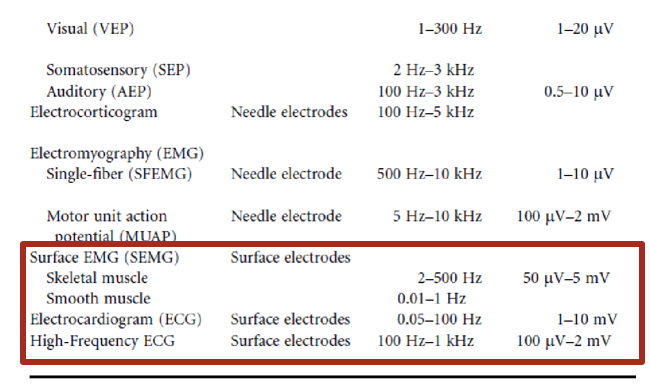

La señal ECG va de 0.05-100 Hz
Hay un ruido del músculo liso tiene frecuencias de 0.01-1 Hz
Hay un ruido del músculo liso tiene frecuencias de 2-500 Hz
Y hay un componte de ECG de alta frecuencia de 100-1000 Hz que se pierde debido al ruido muscular

Es por ello que se le realizará un filtro notch en 60 Hz, un filtro pasa bajas con frecuencia de corte a 100 hz. Y un filtro pasa altas con frecuencia de rechazo de 0.01 Hz y frecuencia de paso de 0.05 Hz

#FILTROS IIR

##*Filtro Pasa bajos de 100 Hz*

###Filtro IIR

Se muestra el diseño del filtro en Pyfdax
con fpd=100Hz
Fsb=110 Hz

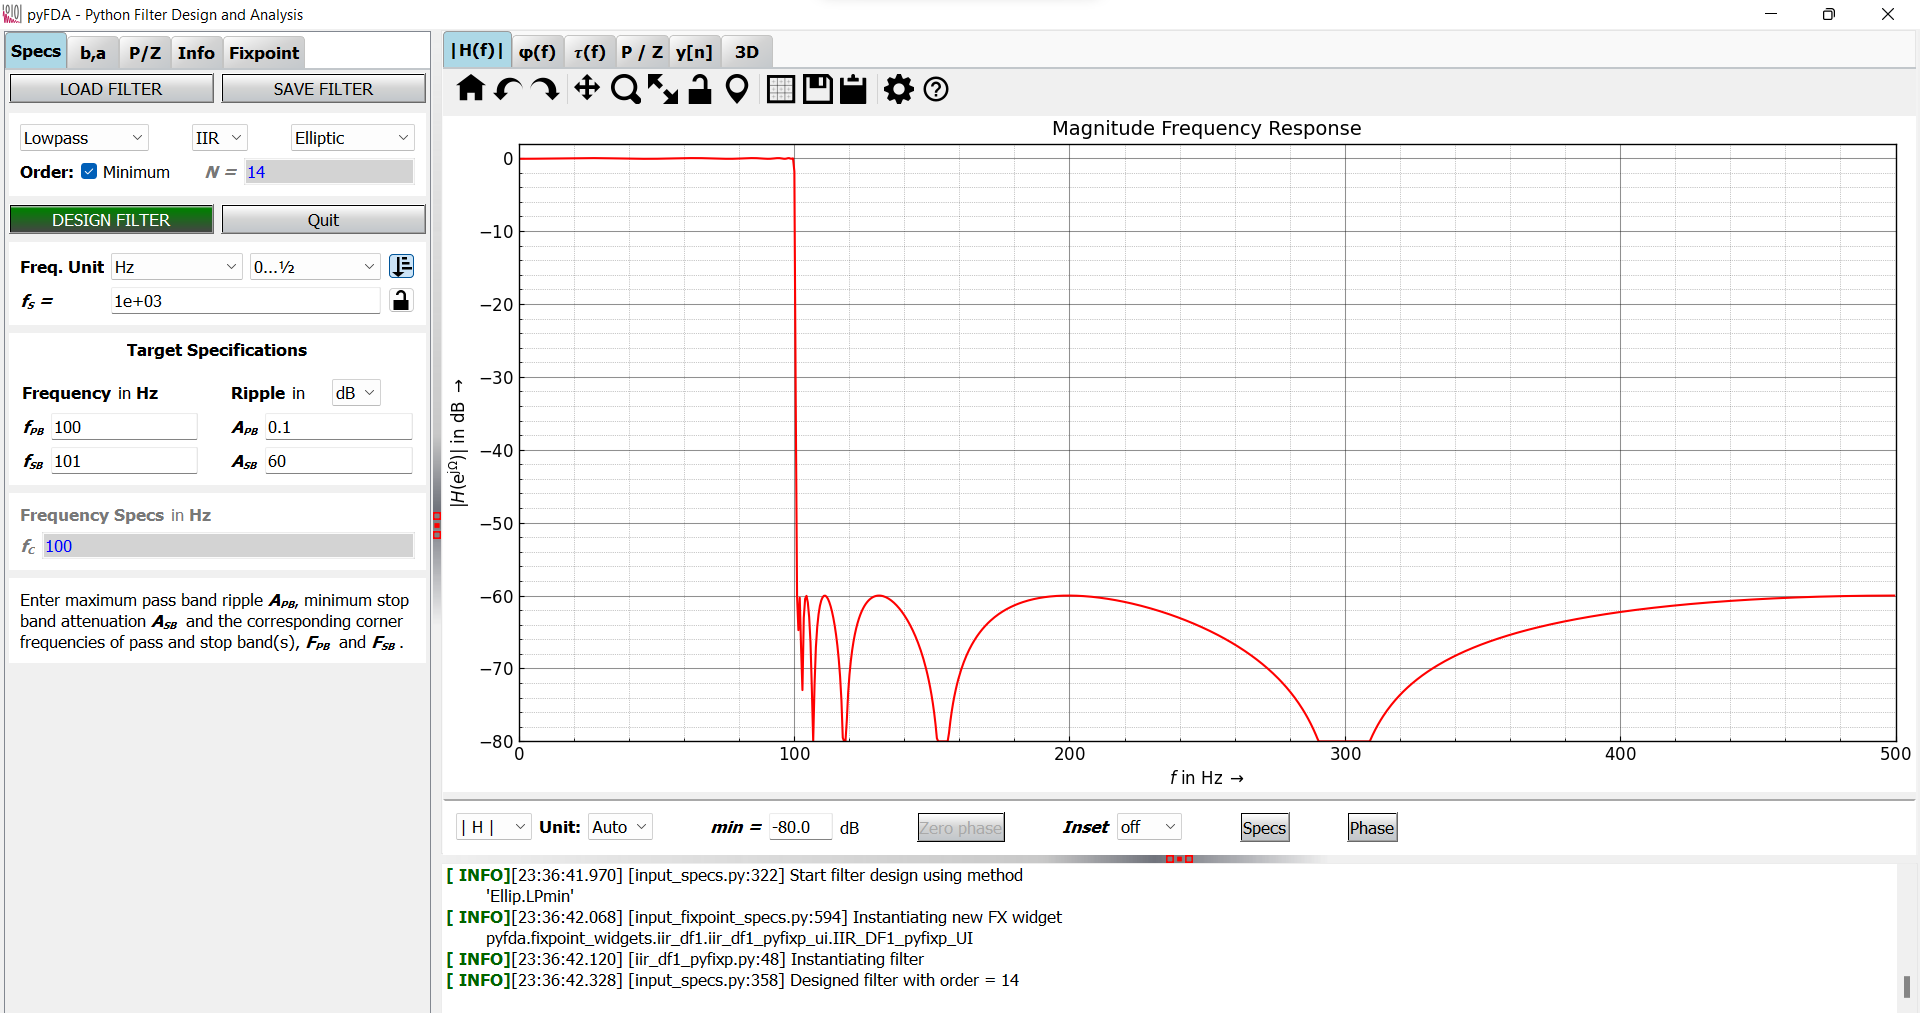

La gráfica de Polos y Ceros, muestra que es un pasa bajas con los polos a la derecha del circulo unitario
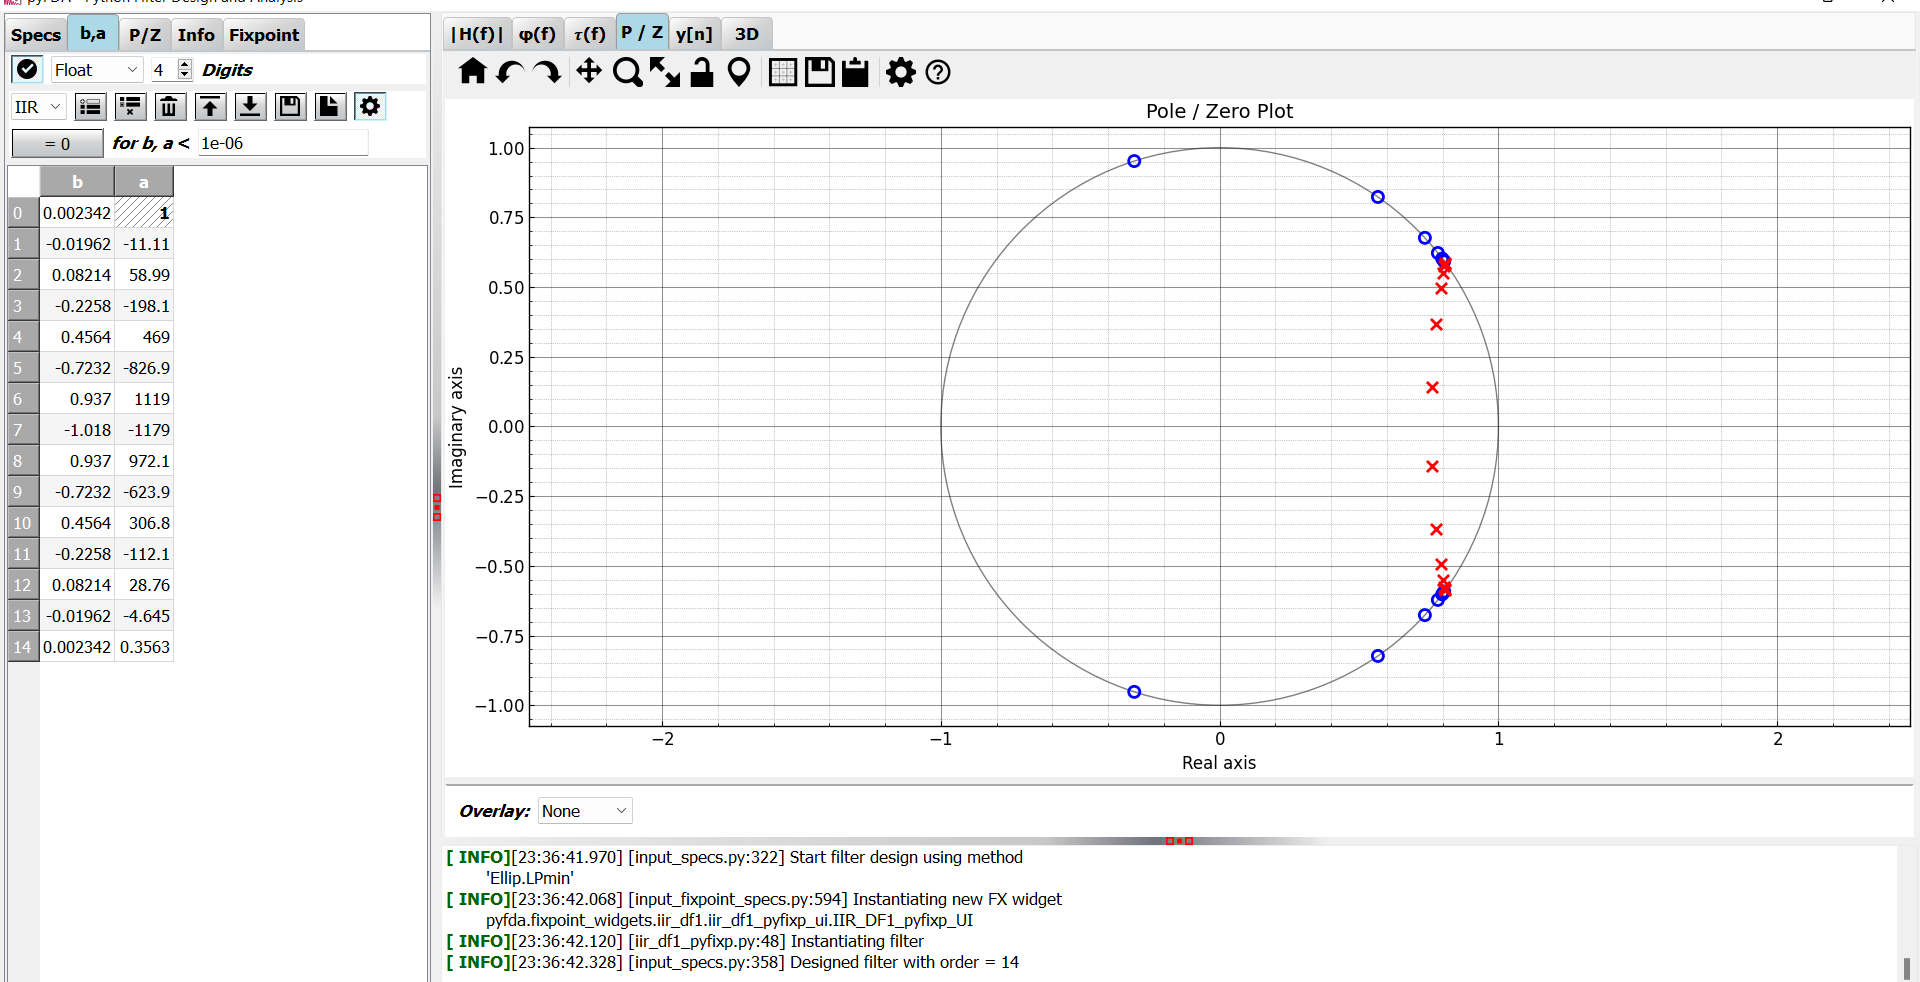

In [ ]:
#Coeficientes del Filtro IIR
with open('filtro IIR 100hz.csv') as csv_file:
    csv_reader = csv.reader(csv_file)
    filter_100=[]
    for row in csv_reader:
        filter_100.append(row)
b_100=np.array(filter_100[0]).T.astype(float)
b_100

array([ 0.00234157, -0.01961556,  0.08214364, -0.22580154,  0.45637163,
       -0.7231711 ,  0.93699038, -1.01844355,  0.93699038, -0.7231711 ,
        0.45637163, -0.22580154,  0.08214364, -0.01961556,  0.00234157])

In [ ]:
a_100=np.array(filter_100[1]).T.astype(float)
a_100

array([ 1.00000000e+00, -1.11063411e+01,  5.89913427e+01, -1.98091658e+02,
        4.68957113e+02, -8.26865875e+02,  1.11869907e+03, -1.17897314e+03,
        9.72113342e+02, -6.23901970e+02,  3.06775771e+02, -1.12073462e+02,
        2.87643389e+01, -4.64471860e+00,  3.56269897e-01])

##*Fitro Notch en 60 Hz*

Se muestra el diseño del filtro en Pyfdax
con fc1=58 Fc2=62

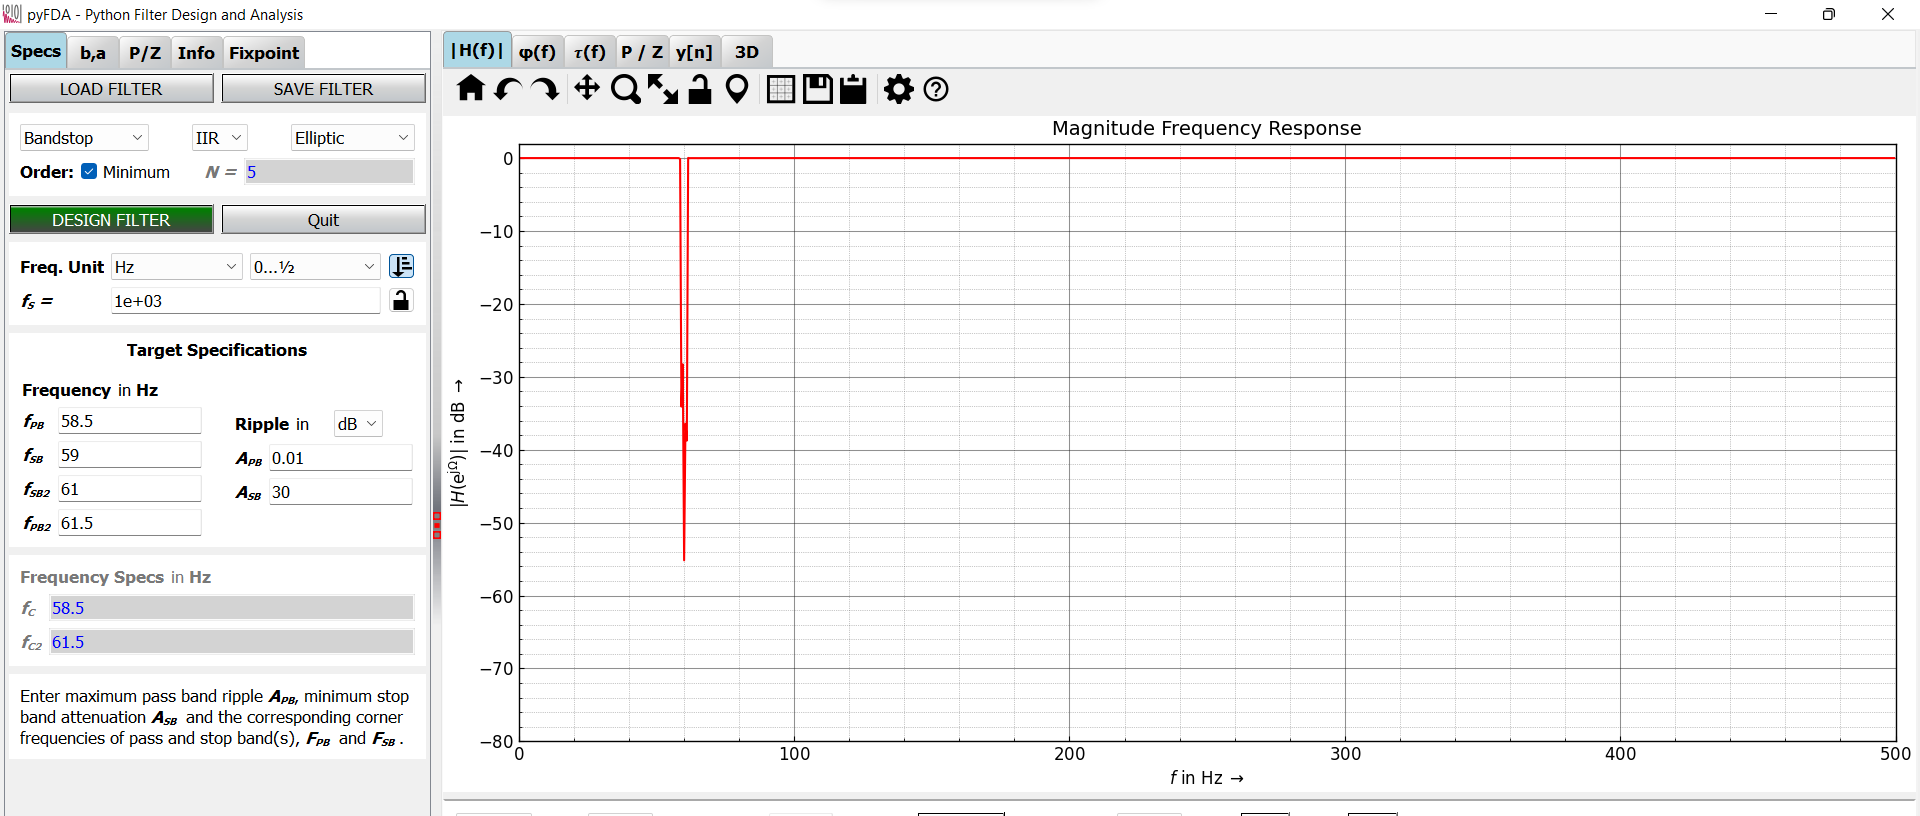

La gráfica de Polos y Ceros, muestra que es un rechaza bandas muy junto sus polos y ceros con los polos a la derecha del circulo unitario

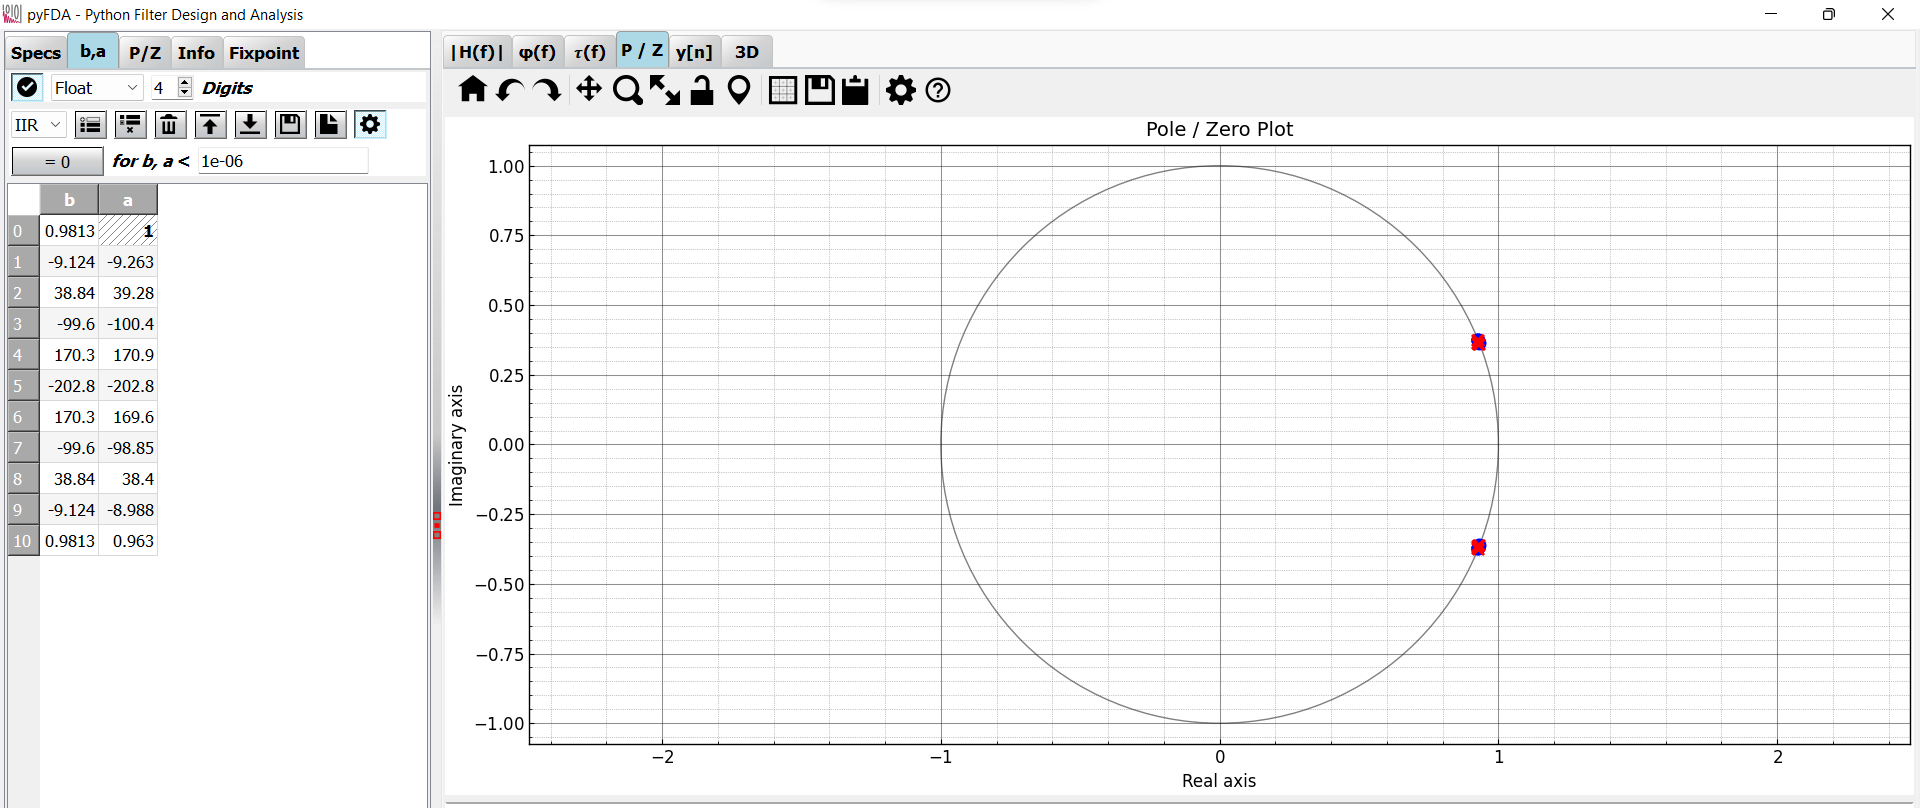

In [ ]:
#Coeficientes del Filtro IIR
with open('filtro IIR notch.csv') as csv_file:
    csv_reader = csv.reader(csv_file)
    filter_noch=[]
    for row in csv_reader:
        filter_noch.append(row)
b_noch=np.array(filter_noch[0]).T.astype(float)
b_noch

array([   0.9813417 ,   -9.12427556,   38.84079197,  -99.59915092,
        170.28624983, -202.76986049,  170.28624983,  -99.59915092,
         38.84079197,   -9.12427556,    0.9813417 ])

In [ ]:
a_noch=np.array(filter_noch[1]).T.astype(float)
a_noch

array([   1.        ,   -9.26273562,   39.2817273 , -100.35068787,
        170.92562147, -202.76572176,  169.64261365,  -98.84983004,
         38.40377652,   -8.98773815,    0.96302805])

##*Fitro PASA ALTAS en 0.01 Hz*

###Filtro IIR

Se muestra el diseño del filtro en Pyfdax
con fs=0.01 fp=0.05

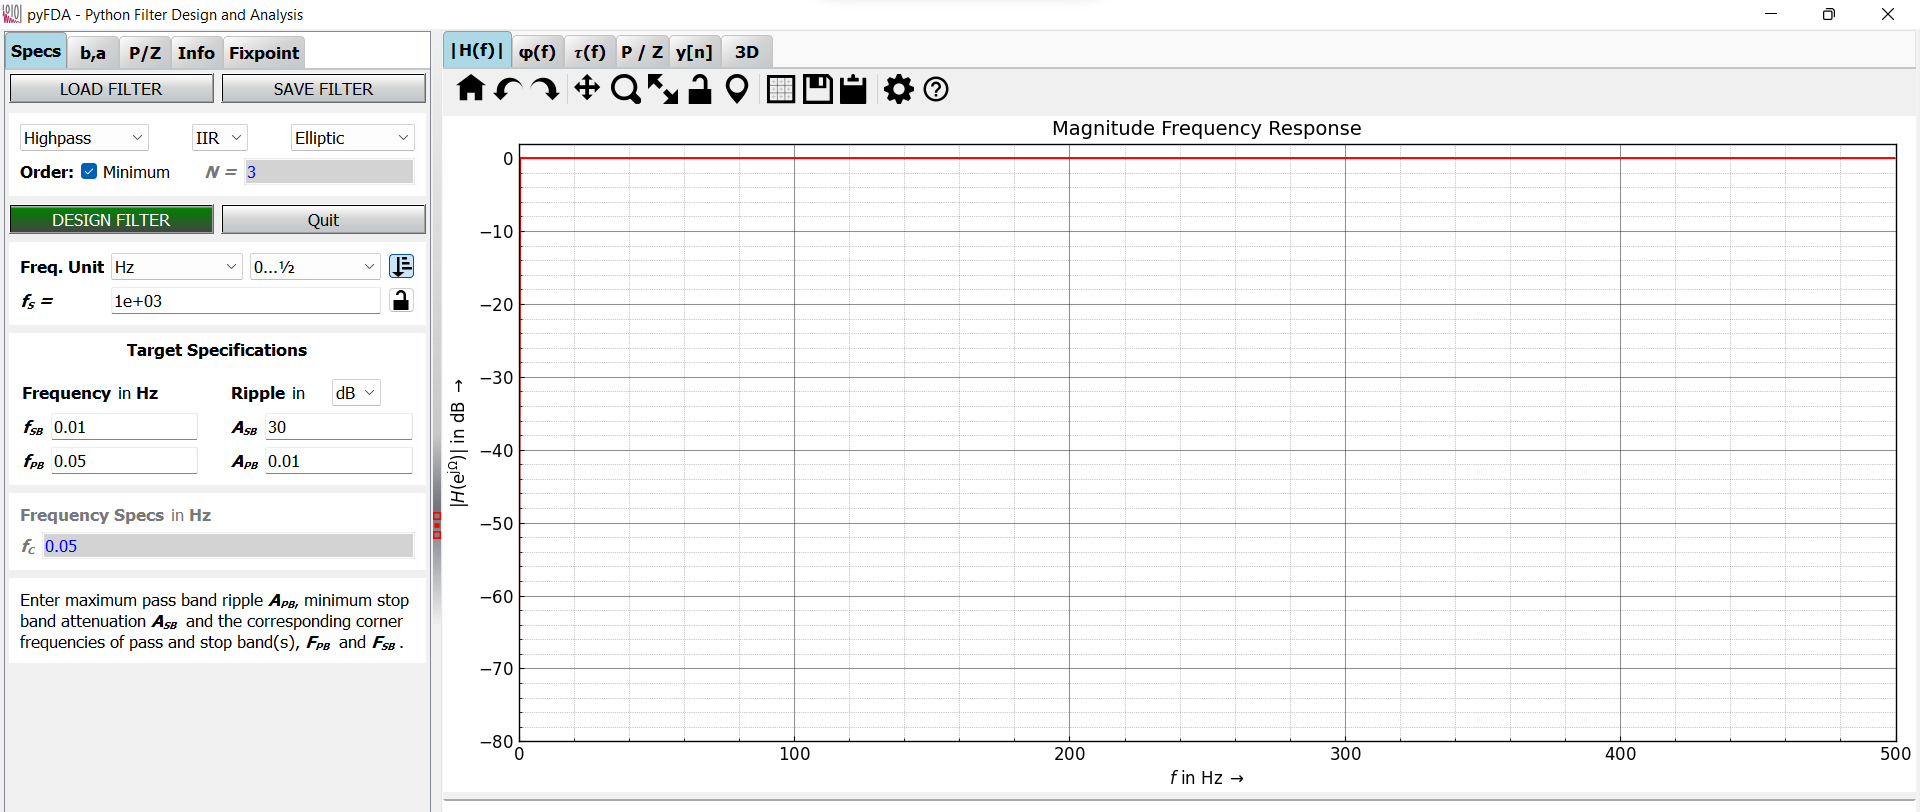

La gráfica de Polos y Ceros, muestra muy junto sus polos y ceros con los polos a la derecha del circulo unitario

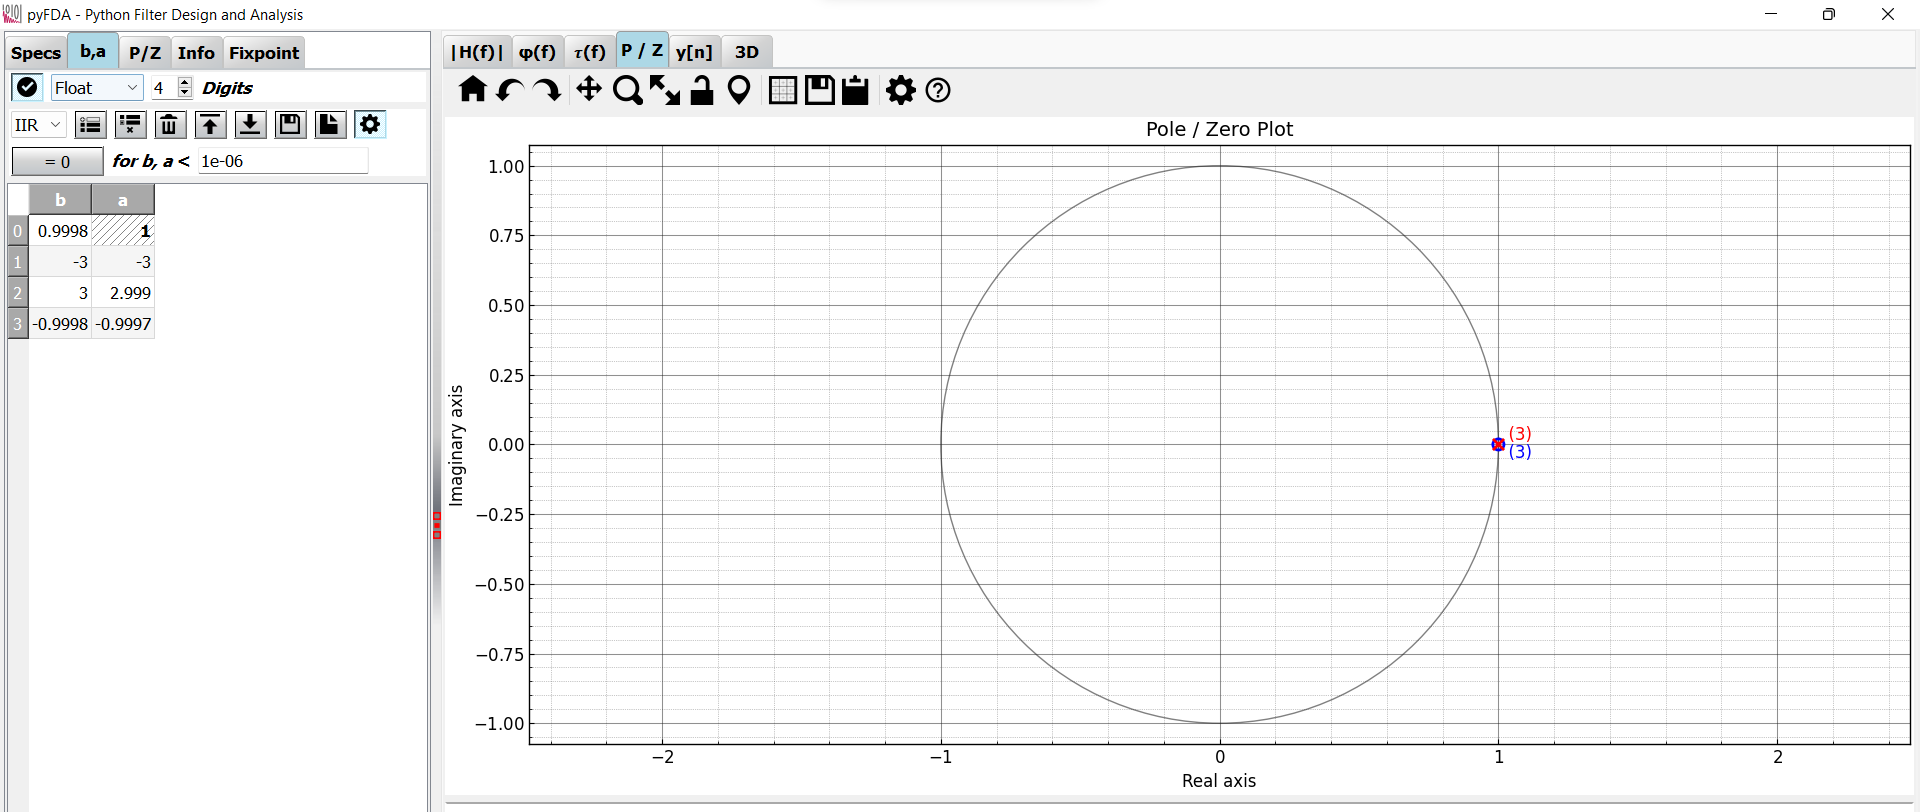

In [ ]:
#Coeficientes del Filtro IIR
with open('filtro IIR hight.csv') as csv_file:
    csv_reader = csv.reader(csv_file)
    filter_hight=[]
    for row in csv_reader:
        filter_hight.append(row)
b_hight=np.array(filter_hight[0]).T.astype(float)
b_hight

array([ 0.99983889, -2.99951665,  2.99951665, -0.99983889])

In [ ]:
a_hight=np.array(filter_hight[1]).T.astype(float)
a_hight

array([ 1.        , -2.99967774,  2.99935554, -0.9996778 ])

#FILTRANDOS LAS SEÑALES POR LOS 3 FILTROS IRR

####Filtrando la Señal de Notch

Text(0, 0.5, 'mV')

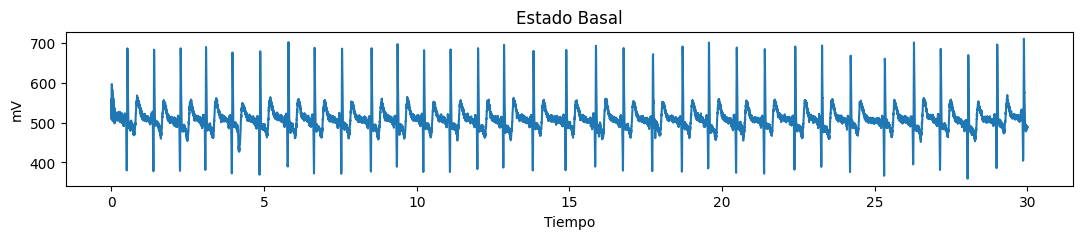

In [ ]:
y_noch = signal.lfilter(b_noch,a_noch, base_total)
#Mostrando
plt.figure(figsize=(13,2)) #Modificamos el tamaño de la gráfica
plt.plot(t, y_noch)
plt.title("Estado Basal")
plt.xlabel('Tiempo')
plt.ylabel('mV')

####Filtrando la Señal de 100 Hz

(5.0, 8.0)

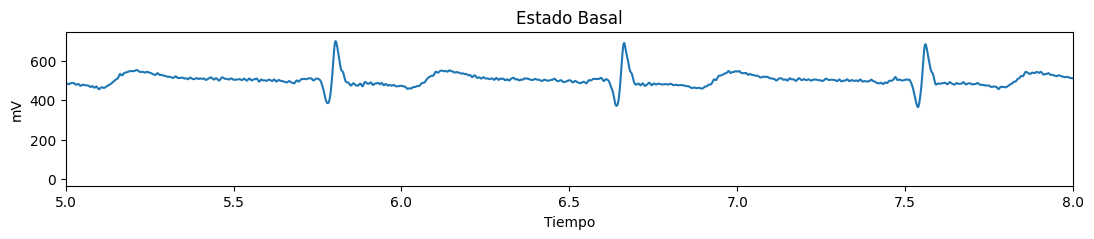

In [ ]:
y_100 = signal.lfilter(b_100,a_100, y_noch)
#Mostrando
plt.figure(figsize=(13,2)) #Modificamos el tamaño de la gráfica
plt.plot(t, y_100)
plt.title("Estado Basal")
plt.xlabel('Tiempo')
plt.ylabel('mV')
plt.xlim(5,8)


####Filtrando la Señal por un pasa altas

(5.0, 8.0)

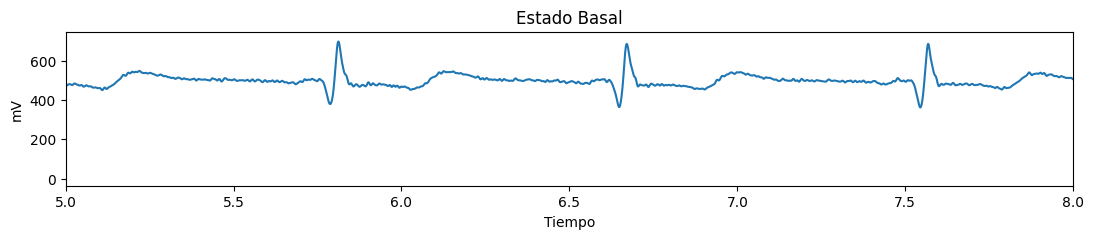

In [ ]:
y_hight = signal.lfilter(b_100,a_100, y_100)
#y_hight=y_hight[100:-1]
n = np.arange(0,y_hight.shape[0])  # t = n*Ts ; Ventor de numeros de datos
t = n*Ts #VECTOR TIEMPO 
#Mostrando
plt.figure(figsize=(13,2)) #Modificamos el tamaño de la gráfica
plt.plot(t, y_hight)
plt.title("Estado Basal")
plt.xlabel('Tiempo')
plt.ylabel('mV')
plt.xlim(5,8)


#Graficar Su frecuencia Filtrada


(1024,)


Text(0, 0.5, '|X|')

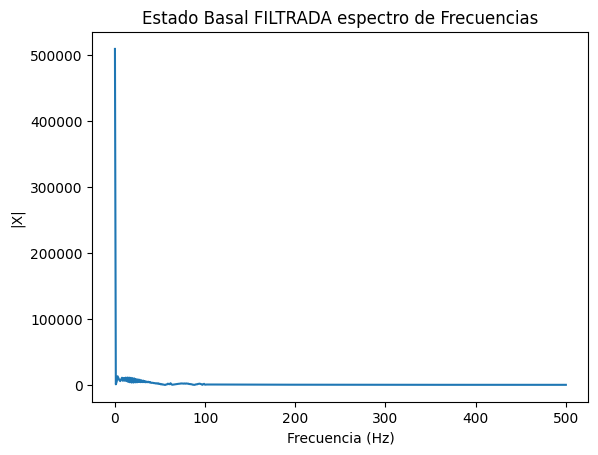

In [ ]:
N = 2**10 #Resolución
fs=1000
base_frec_filt = np.fft.fft(y_hight,N)
print(base_frec_filt.shape)
base_frec_filt= base_frec_filt[0:(N//2)]
#magnitud
base_frecm_filt = np.abs(base_frec_filt)
base_frecm_filt = np.round(base_frecm_filt,3)
#frecuencias
F = np.linspace(0, Fs/2, N//2)
#eje de tiempo en seg
t = n/Fs
plt.plot(F,base_frecm_filt)
plt.title("Estado Basal FILTRADA espectro de Frecuencias")
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('|X|')

(0.0, 9000.0)

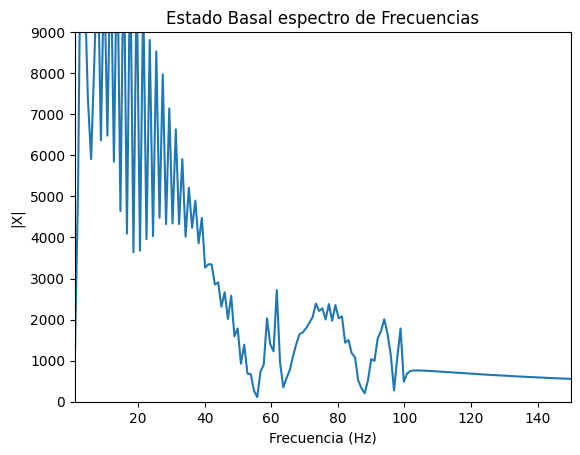

In [ ]:
plt.plot(F,base_frecm_filt)
plt.title("Estado Basal espectro de Frecuencias")
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('|X|')
plt.xlim(1,150)
plt.ylim(0,9000)

#Para Cada estado ECG IIR

Text(0, 0.5, 'mV')

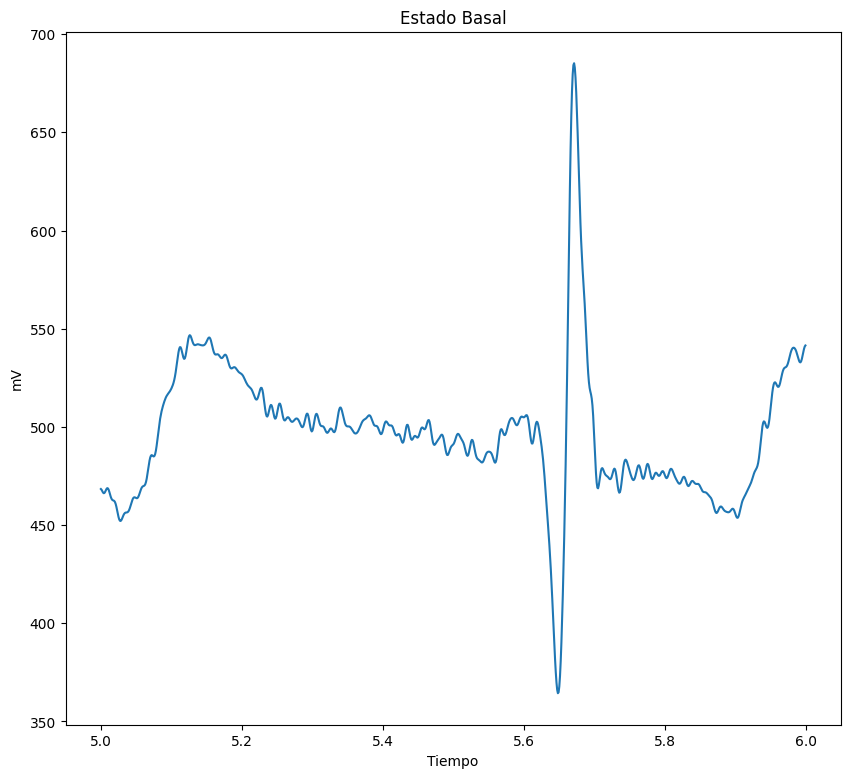

In [ ]:
plt.figure(figsize=(10,9)) #Modificamos el tamaño de la gráfica
plt.plot(t[5000:6000], y_hight[6000:7000])
plt.title("Estado Basal")
plt.xlabel('Tiempo')
plt.ylabel('mV')

## Visualizando estado de respiraicón


Text(0, 0.5, 'mV')

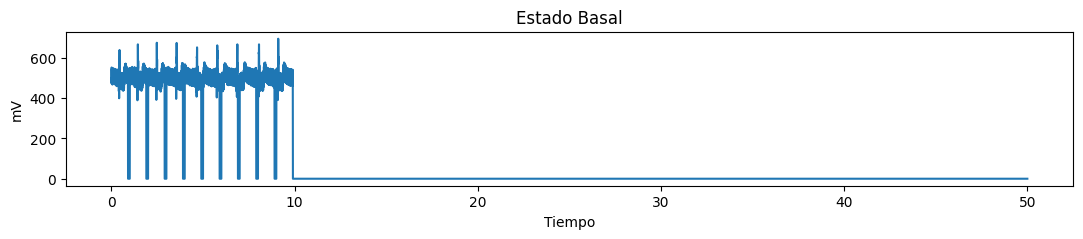

In [ ]:
#Mostrar datos en el tiempo
respiracion=np.reshape(respiracion,-1)
#Frecuencia de muestreo del dispositivo de adquisición
Fs = 1000 
Ts=1/Fs
n = np.arange(0,base_r.shape[0])  # t = n*Ts ; Ventor de numeros de datos
t = n*Ts #VECTOR TIEMPO 
plt.figure(figsize=(13,2)) #Modificamos el tamaño de la gráfica
plt.plot(t, respiracion)
plt.title("Estado Basal")
plt.xlabel('Tiempo')
plt.ylabel('mV')

### Cortando la señal

Text(0, 0.5, 'mV')

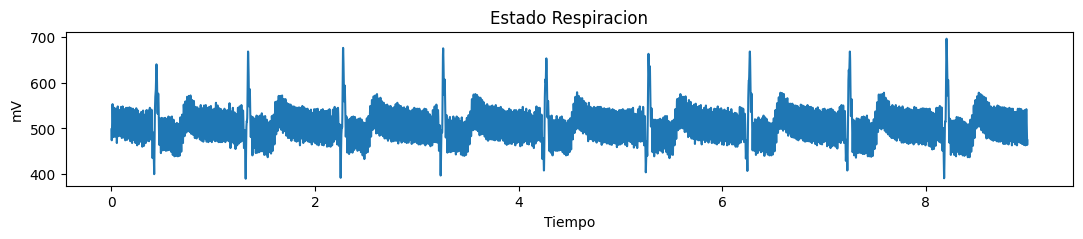

In [ ]:
#DEBIDO A QUE A PARTIR DE SON 3000 DATOS DE LOS 5000
#=base_r[0:30000]
respiracion_total=respiracion[np.nonzero(respiracion)]

Ts=1/1000
n = np.arange(0,respiracion_total.shape[0])  # t = n*Ts ; Ventor de numeros de datos
t = n*Ts #VECTOR TIEMPO 
plt.figure(figsize=(13,2)) #Modificamos el tamaño de la gráfica
plt.plot(t, respiracion_total)
plt.title("Estado Respiracion")
plt.xlabel('Tiempo')
plt.ylabel('mV')

### Aplicando los filtros

Filtro Notch

Text(0, 0.5, 'mV')

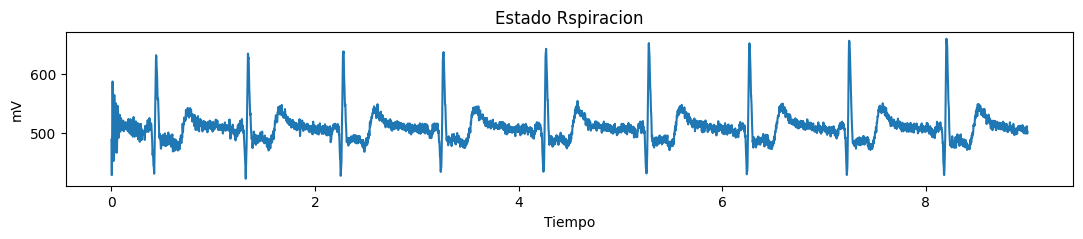

In [ ]:
y_noch = signal.lfilter(b_noch,a_noch, respiracion_total)
#Mostrando
plt.figure(figsize=(13,2)) #Modificamos el tamaño de la gráfica
plt.plot(t, y_noch)
plt.title("Estado Rspiracion")
plt.xlabel('Tiempo')
plt.ylabel('mV')

Filtro pasabajas

Text(0, 0.5, 'mV')

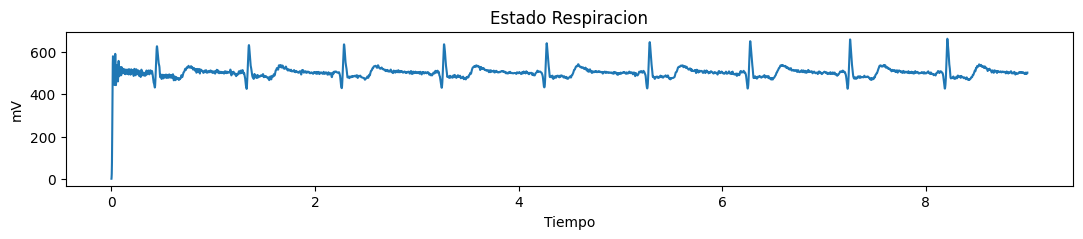

In [ ]:
y_100 = signal.lfilter(b_100,a_100, y_noch)
#Mostrando
plt.figure(figsize=(13,2)) #Modificamos el tamaño de la gráfica
plt.plot(t, y_100)
plt.title("Estado Respiracion")
plt.xlabel('Tiempo')
plt.ylabel('mV')
#plt.xlim(5,8)

Filtro pasaaltas

Text(0, 0.5, 'mV')

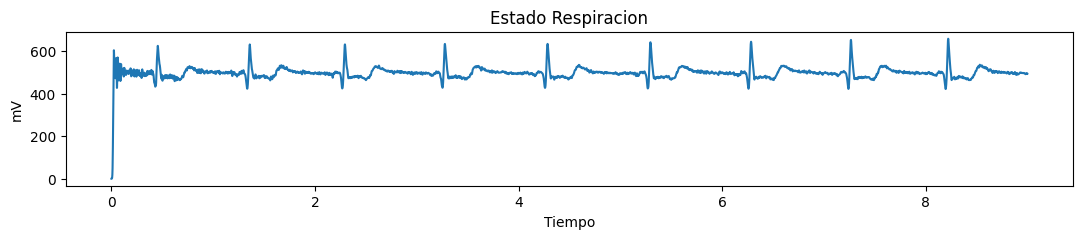

In [ ]:
y_hight = signal.lfilter(b_100,a_100, y_100)
#y_hight=y_hight[100:-1]
n = np.arange(0,y_hight.shape[0])  # t = n*Ts ; Ventor de numeros de datos
t = n*Ts #VECTOR TIEMPO 
#Mostrando
plt.figure(figsize=(13,2)) #Modificamos el tamaño de la gráfica
plt.plot(t, y_hight)
plt.title("Estado Respiracion")
plt.xlabel('Tiempo')
plt.ylabel('mV')
#plt.xlim(5,8)


Text(0, 0.5, 'mV')

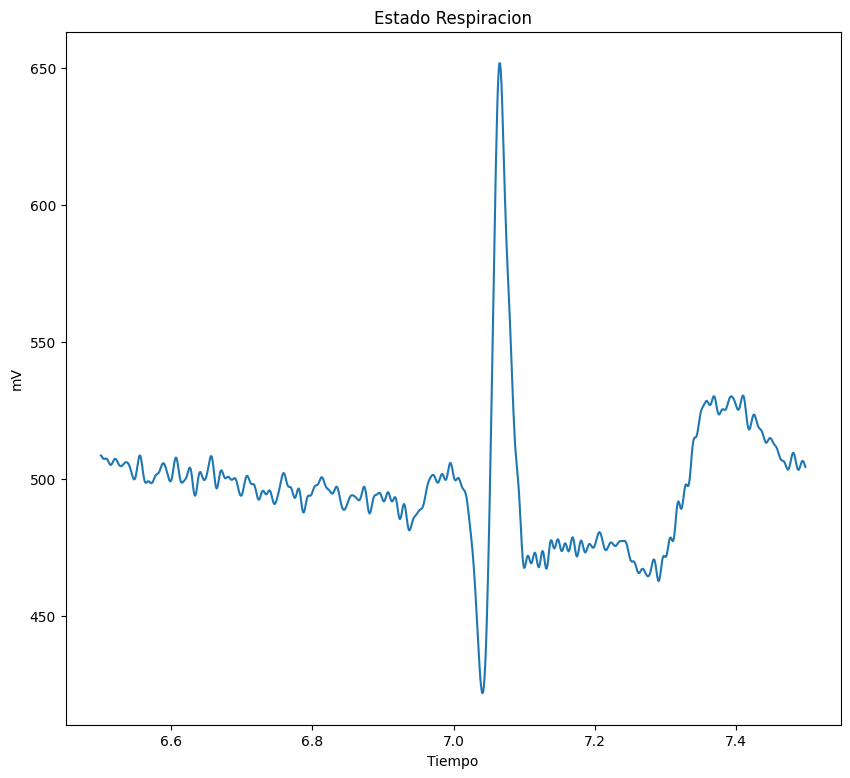

In [ ]:
plt.figure(figsize=(10,9)) #Modificamos el tamaño de la gráfica
plt.plot(t[6500:7500], y_hight[6700:7700])
plt.title("Estado Respiracion")
plt.xlabel('Tiempo')
plt.ylabel('mV')

## Visualizando la señal de post Ejercicio

Text(0, 0.5, 'mV')

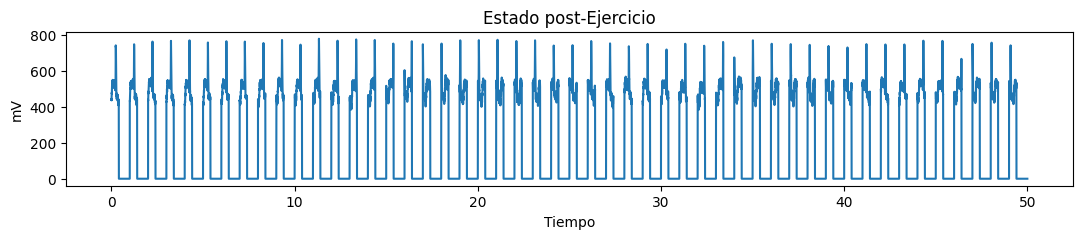

In [ ]:
#Mostrar datos en el tiempo
Ejer=np.reshape(post_ejercicio,-1)
#Frecuencia de muestreo del dispositivo de adquisición
Fs = 1000 
Ts=1/Fs
n = np.arange(0,Ejer.shape[0])  # t = n*Ts ; Ventor de numeros de datos
t = n*Ts #VECTOR TIEMPO 
plt.figure(figsize=(13,2)) #Modificamos el tamaño de la gráfica
plt.plot(t, Ejer)
plt.title("Estado post-Ejercicio")
plt.xlabel('Tiempo')
plt.ylabel('mV')

### Cortando señal

Text(0, 0.5, 'mV')

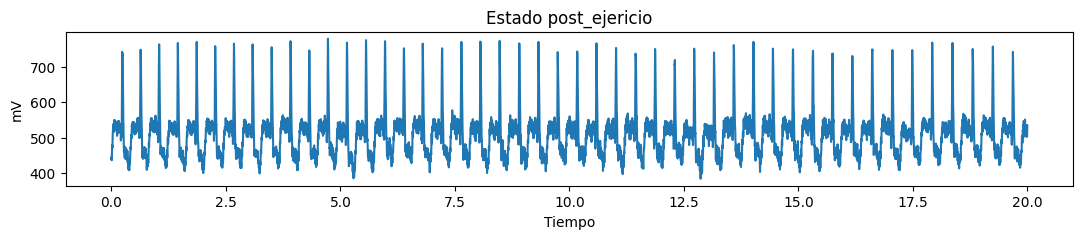

In [ ]:
#DEBIDO A QUE A PARTIR DE SON 3000 DATOS DE LOS 5000
#=base_r[0:30000]
ejer_total=Ejer[np.nonzero(Ejer)]

Ts=1/1000
n = np.arange(0,ejer_total.shape[0])  # t = n*Ts ; Ventor de numeros de datos
t = n*Ts #VECTOR TIEMPO 
plt.figure(figsize=(13,2)) #Modificamos el tamaño de la gráfica
plt.plot(t, ejer_total)
plt.title("Estado post_ejericio")
plt.xlabel('Tiempo')
plt.ylabel('mV')

### Aplicando Filtros

Filtro Notch

Text(0, 0.5, 'mV')

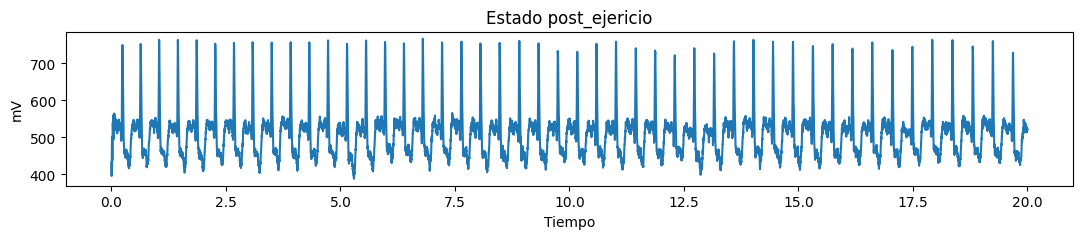

In [ ]:
y_noch = signal.lfilter(b_noch,a_noch, ejer_total)
#Mostrando
plt.figure(figsize=(13,2)) #Modificamos el tamaño de la gráfica
plt.plot(t, y_noch)
plt.title("Estado post_ejericio")
plt.xlabel('Tiempo')
plt.ylabel('mV')

Filtro pasa bajas

Text(0, 0.5, 'mV')

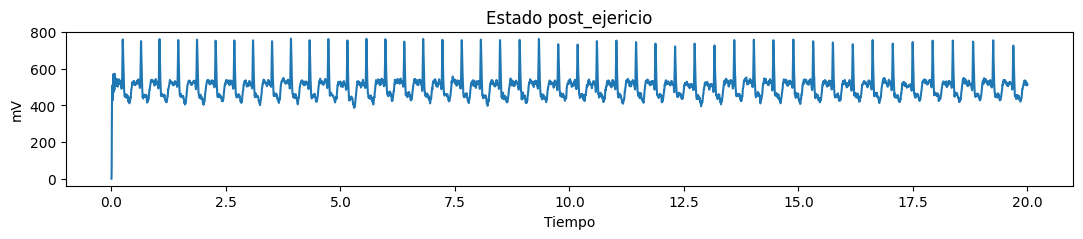

In [ ]:
y_100 = signal.lfilter(b_100,a_100, y_noch)
#Mostrando
plt.figure(figsize=(13,2)) #Modificamos el tamaño de la gráfica
plt.plot(t, y_100)
plt.title("Estado post_ejericio")
plt.xlabel('Tiempo')
plt.ylabel('mV')
#plt.xlim(5,8)

Filtros pasaaltas

Text(0, 0.5, 'mV')

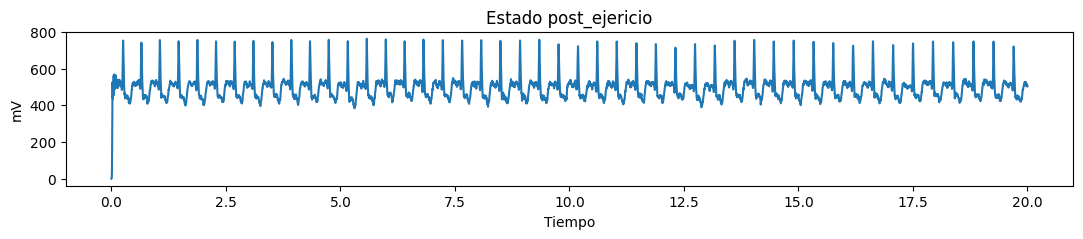

In [ ]:
y_hight = signal.lfilter(b_100,a_100, y_100)
#y_hight=y_hight[100:-1]
n = np.arange(0,y_hight.shape[0])  # t = n*Ts ; Ventor de numeros de datos
t = n*Ts #VECTOR TIEMPO 
#Mostrando
plt.figure(figsize=(13,2)) #Modificamos el tamaño de la gráfica
plt.plot(t, y_hight)
plt.title("Estado post_ejericio")
plt.xlabel('Tiempo')
plt.ylabel('mV')
#plt.xlim(5,8)


Text(0, 0.5, 'mV')

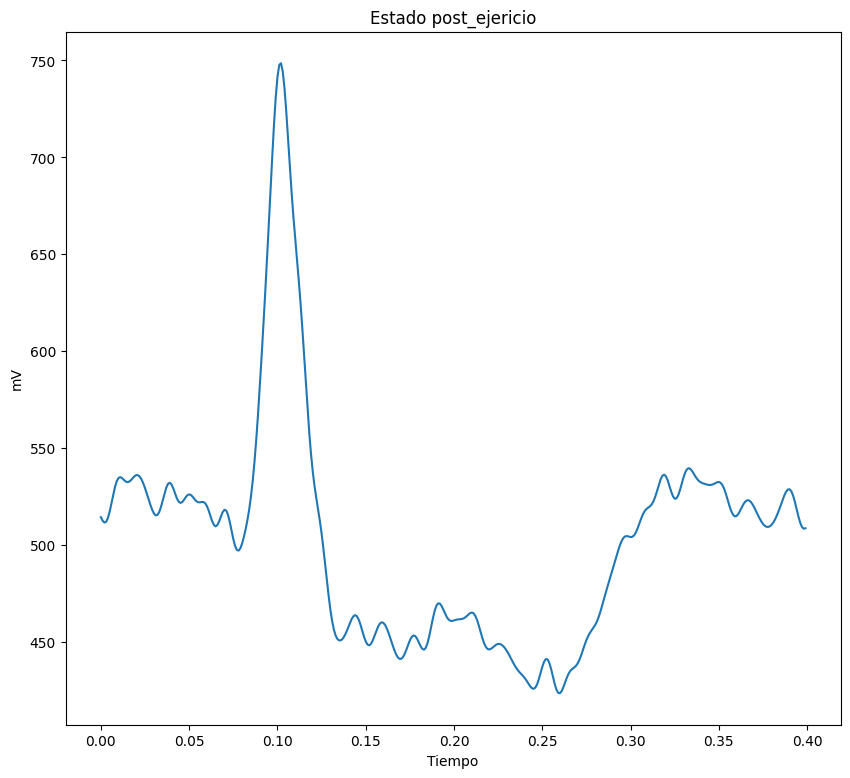

In [ ]:
plt.figure(figsize=(10,9)) #Modificamos el tamaño de la gráfica
plt.plot(t[0:400], y_hight[6300:6700])
plt.title("Estado post_ejericio")
plt.xlabel('Tiempo')
plt.ylabel('mV')

#Filtro FIR

##*Filtro Pasa bajos de 100 Hz*

Se muestra el diseño del filtro en Pyfdax
con fpd=100Hz
Fsb=110 Hz

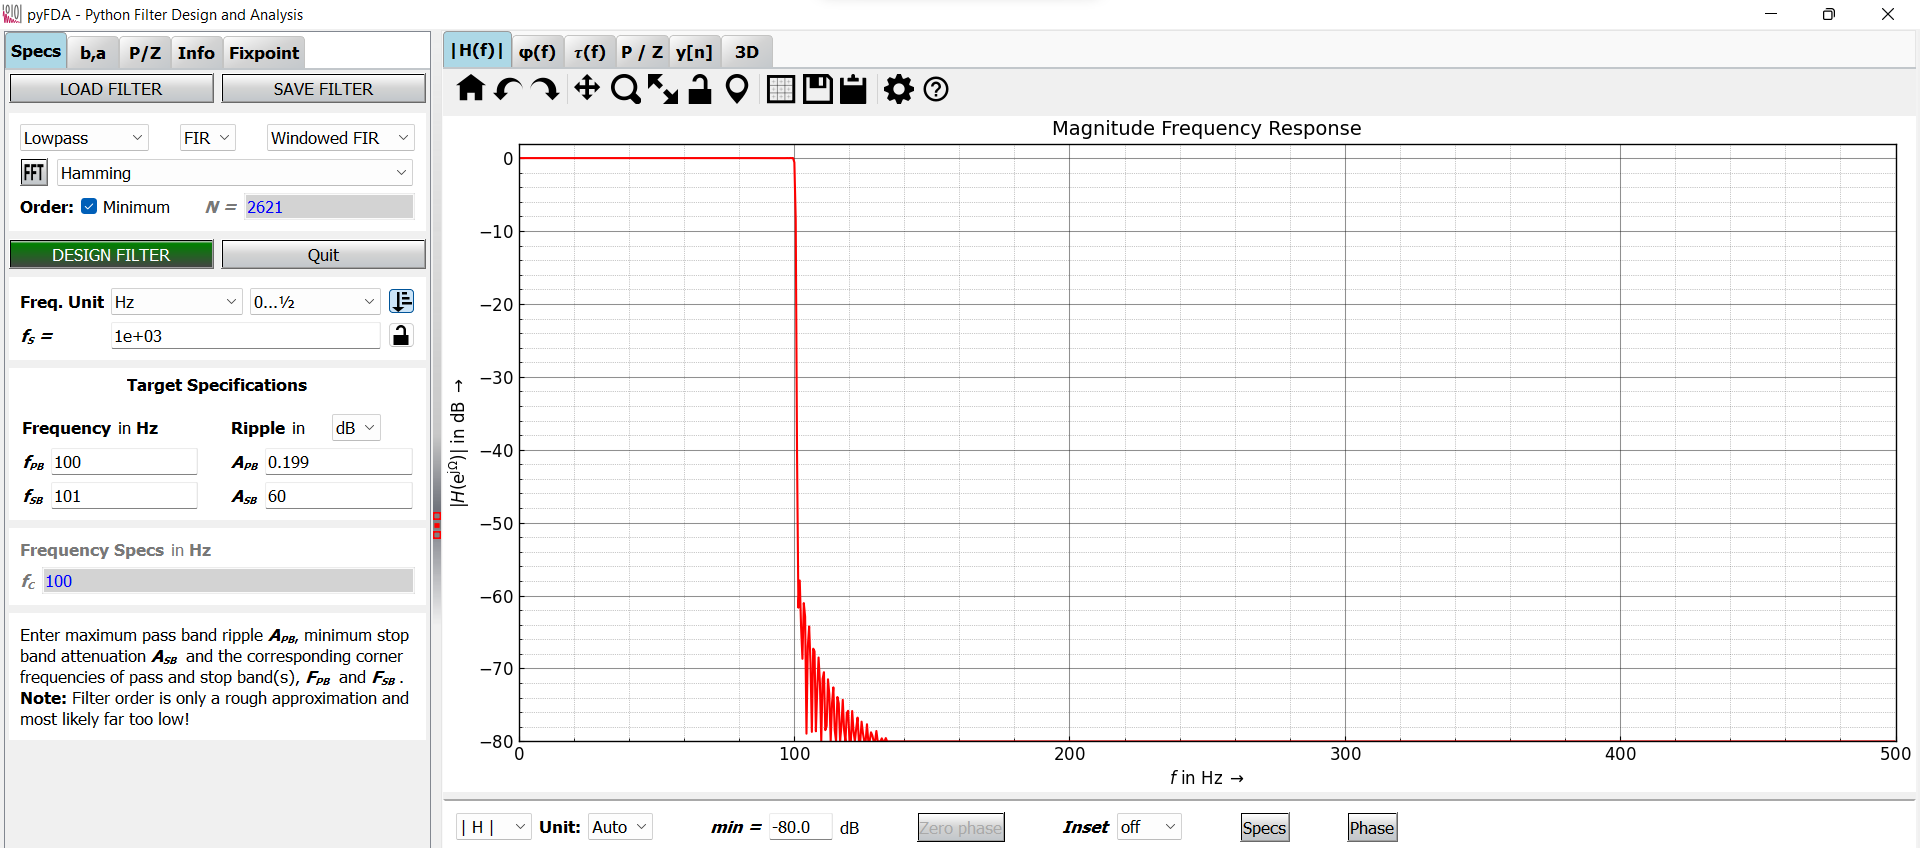

La gráfica de Polos y Ceros, muestra muchos ceros en todo el circulo unitario y dos puntos a la derecha del circulo lo que representa un pasa bajas

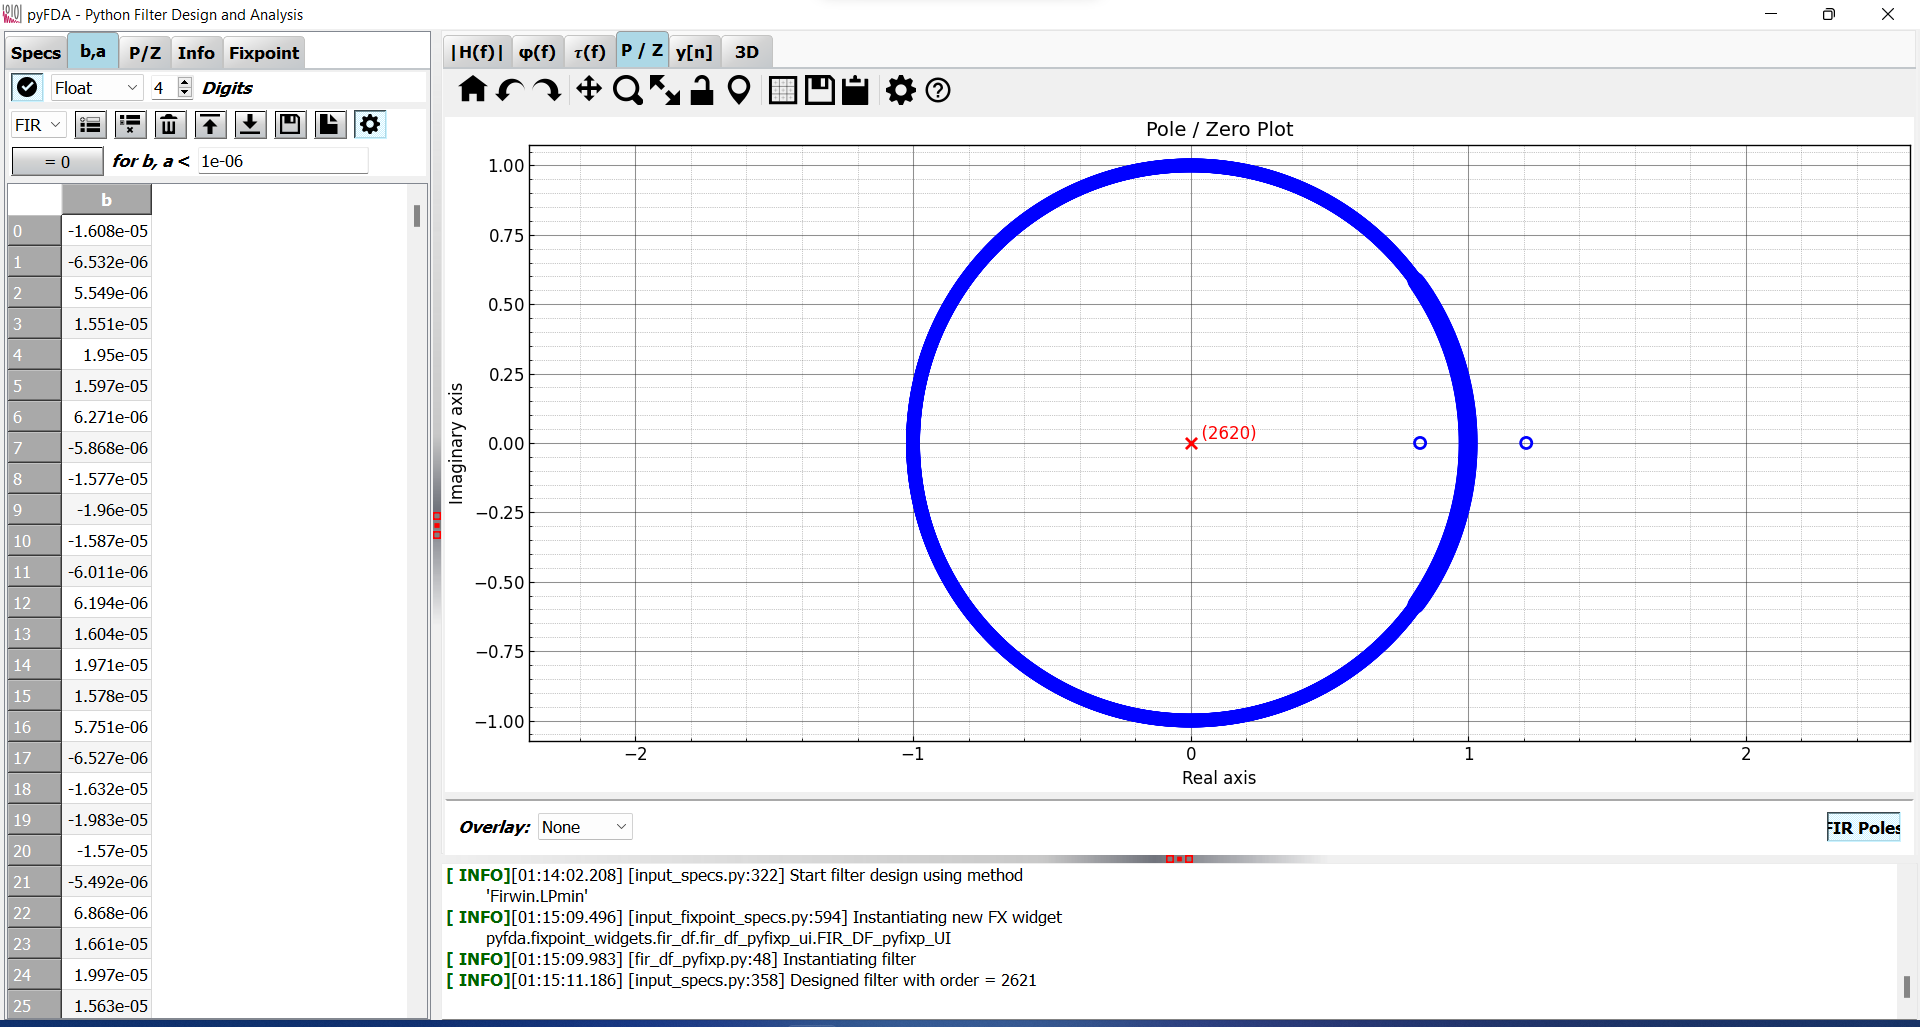

In [ ]:
#Coeficientes del Filtro IIR
with open('filtro FIR 100hz_10.csv') as csv_file:
    csv_reader = csv.reader(csv_file)
    filter_100_FIR=[]
    for row in csv_reader:
        filter_100_FIR.append(row)
b_100_FIR=np.array(filter_100_FIR[0]).T.astype(float)
b_100_FIR

array([-1.60771502e-05, -6.53213883e-06,  5.54916623e-06, ...,
        5.54916623e-06, -6.53213883e-06, -1.60771502e-05])

##*Filtro Notch de 60 Hz*

Se muestra el diseño del filtro en Pyfdax
con fc1=58 Fc2=62


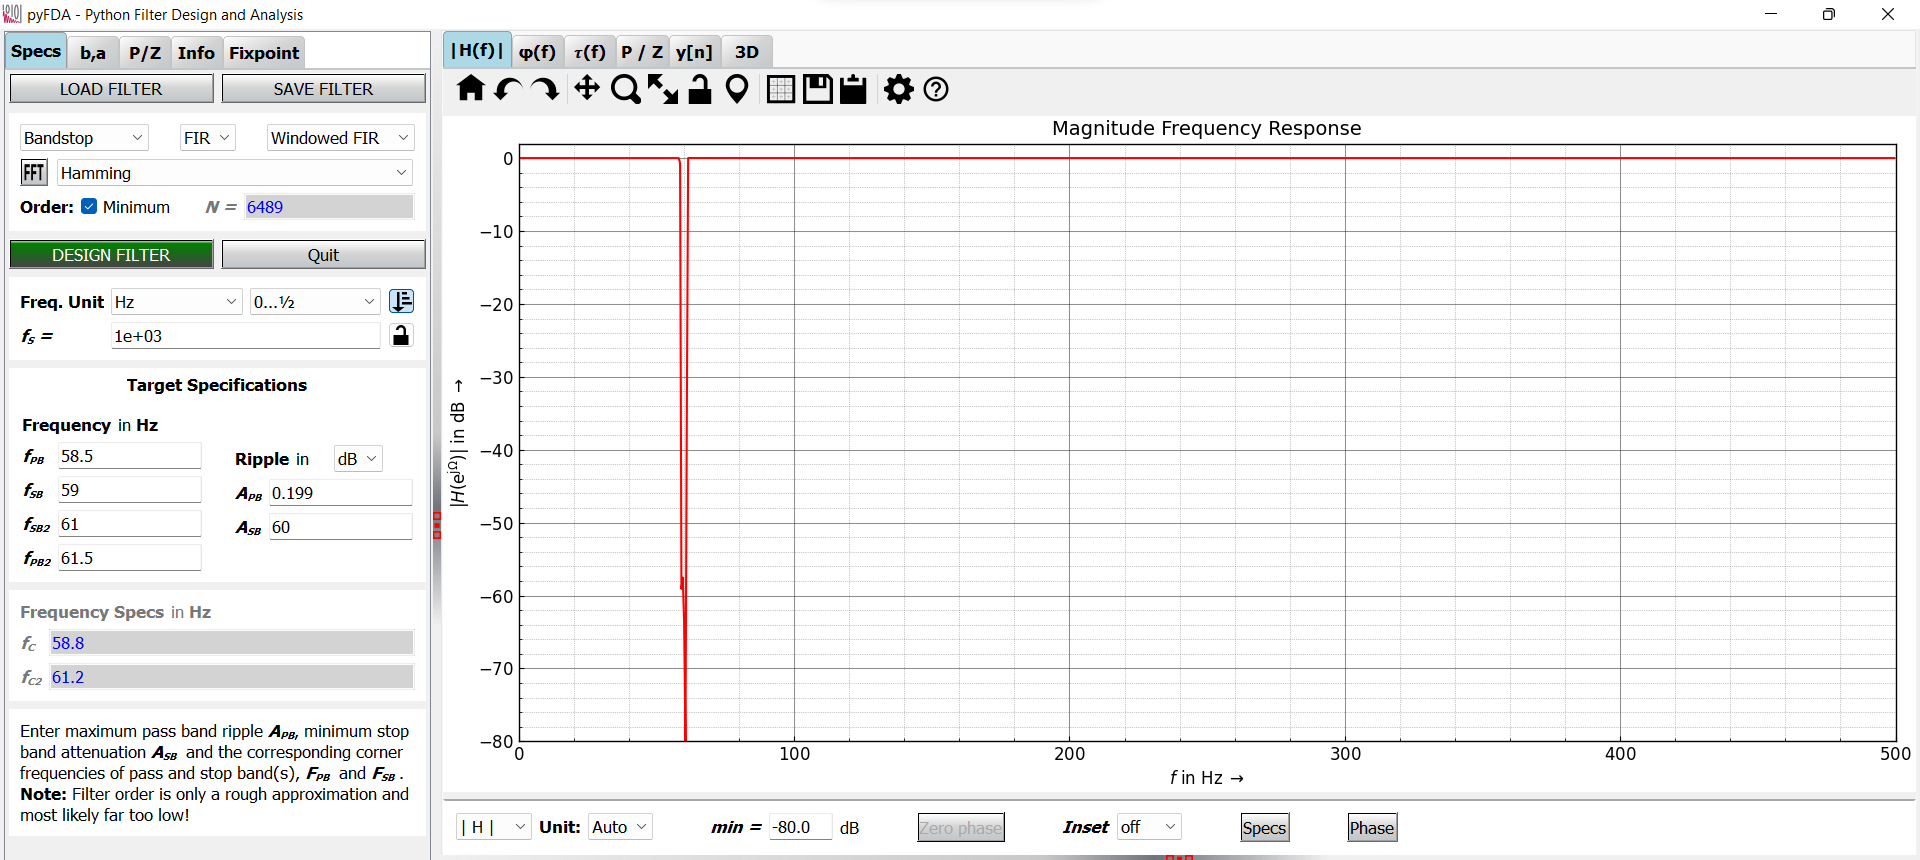

La gráfica de Polos y Ceros, muestra que es un rechaza bandas muy junto sus polos y ceros con los polos a la derecha del circulo unitario

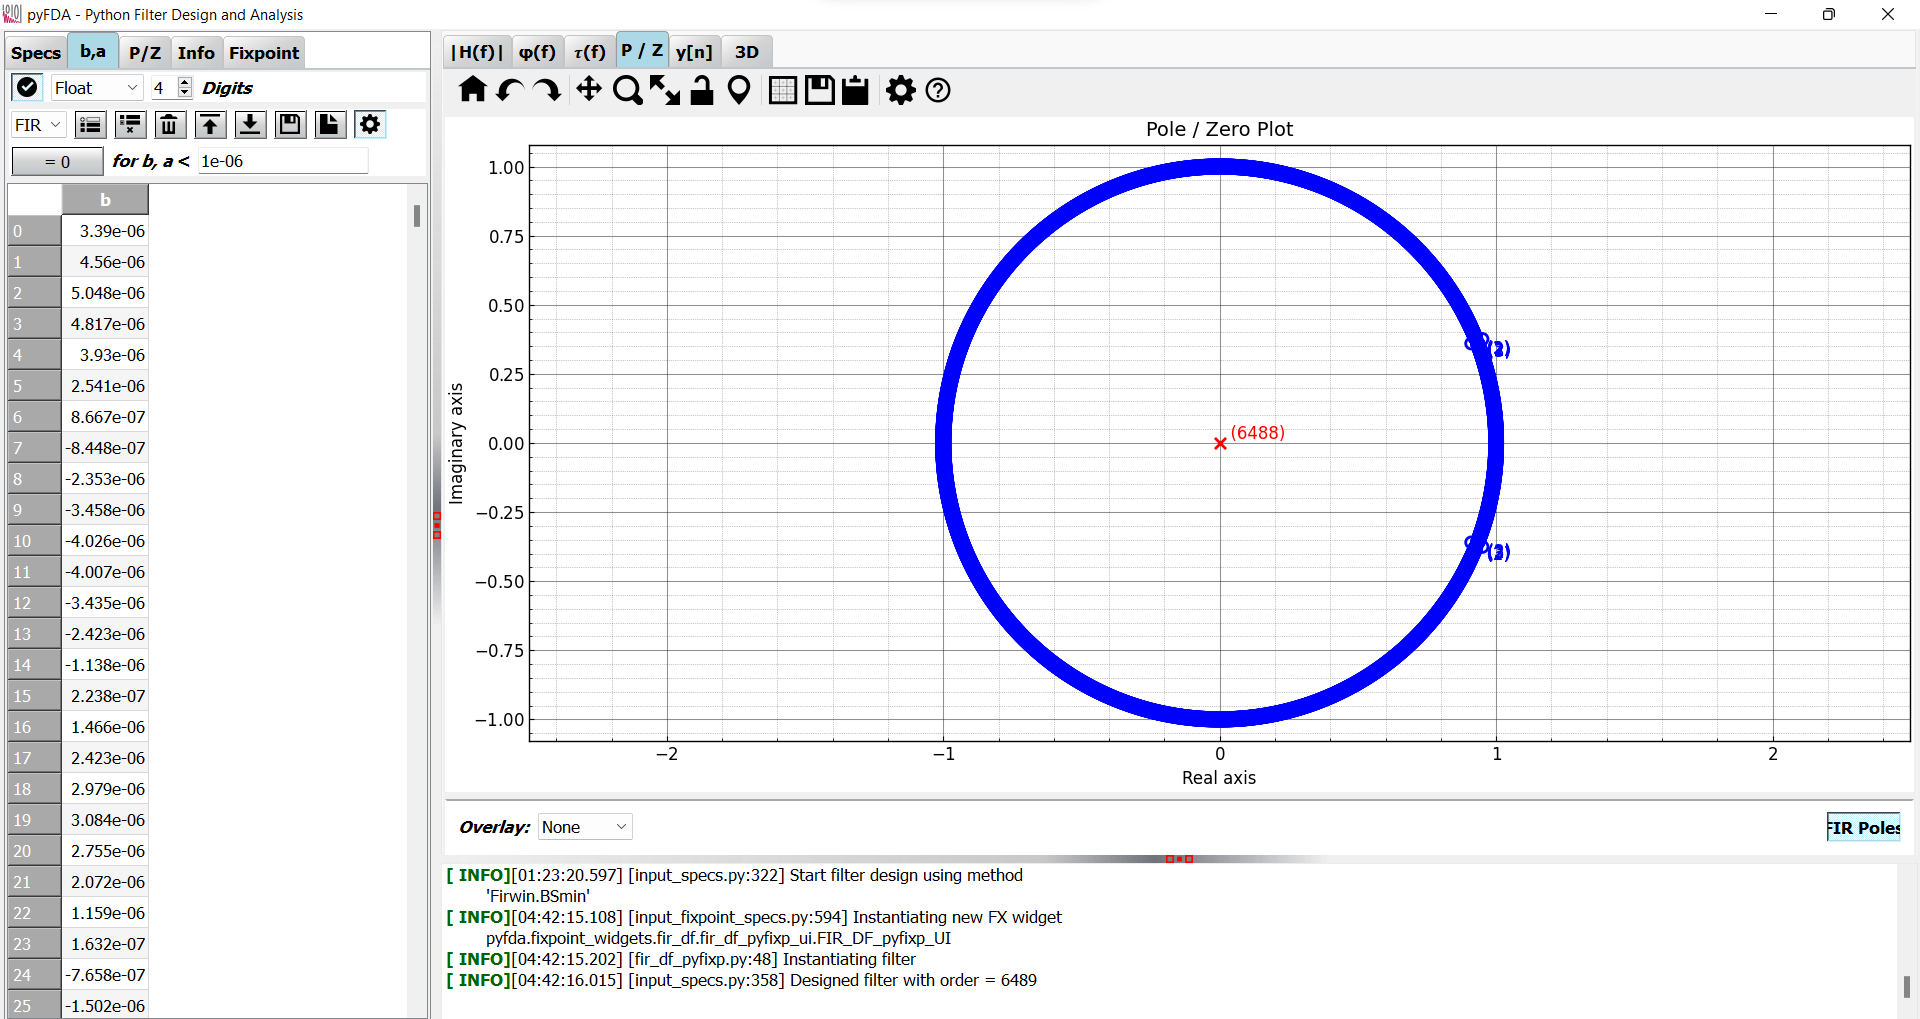

In [ ]:
#Coeficientes del Filtro IIR
with open('filtro FIR notch.csv') as csv_file:
    csv_reader = csv.reader(csv_file)
    filter_notch_FIR=[]
    for row in csv_reader:
        filter_notch_FIR.append(row)
b_notch_FIR=np.array(filter_notch_FIR[0]).T.astype(float)
b_notch_FIR

array([3.38976998e-06, 4.55974230e-06, 5.04831812e-06, ...,
       5.04831812e-06, 4.55974230e-06, 3.38976998e-06])

##*Fitro PASA ALTAS en 0.01 Hz*

Se muestra el diseño del filtro en Pyfdax con fs=0.1 y fp=0.5
Y no con los parametros de IIR de fs=0.01 fp=0.05
Porque se obtiene un orden muy alto


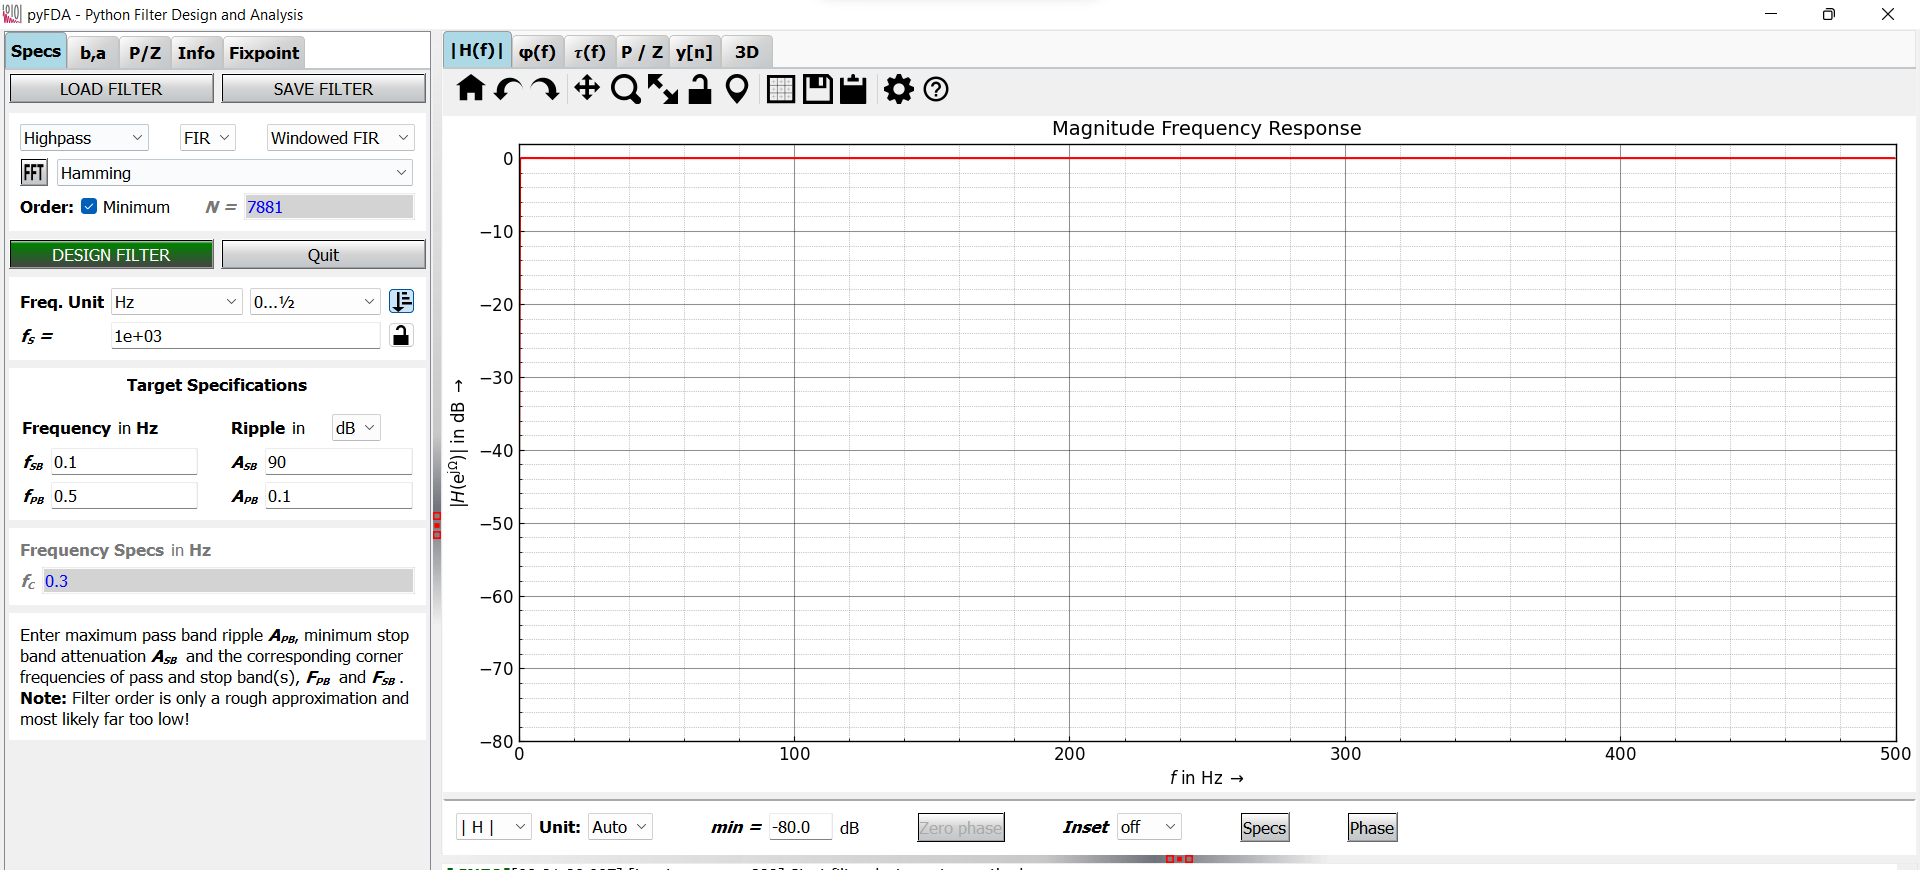

La gráfica de Polos y Ceros, muestra que es un rechaza bandas muy junto sus polos y ceros con los polos muy pegados a los reales puros positivos

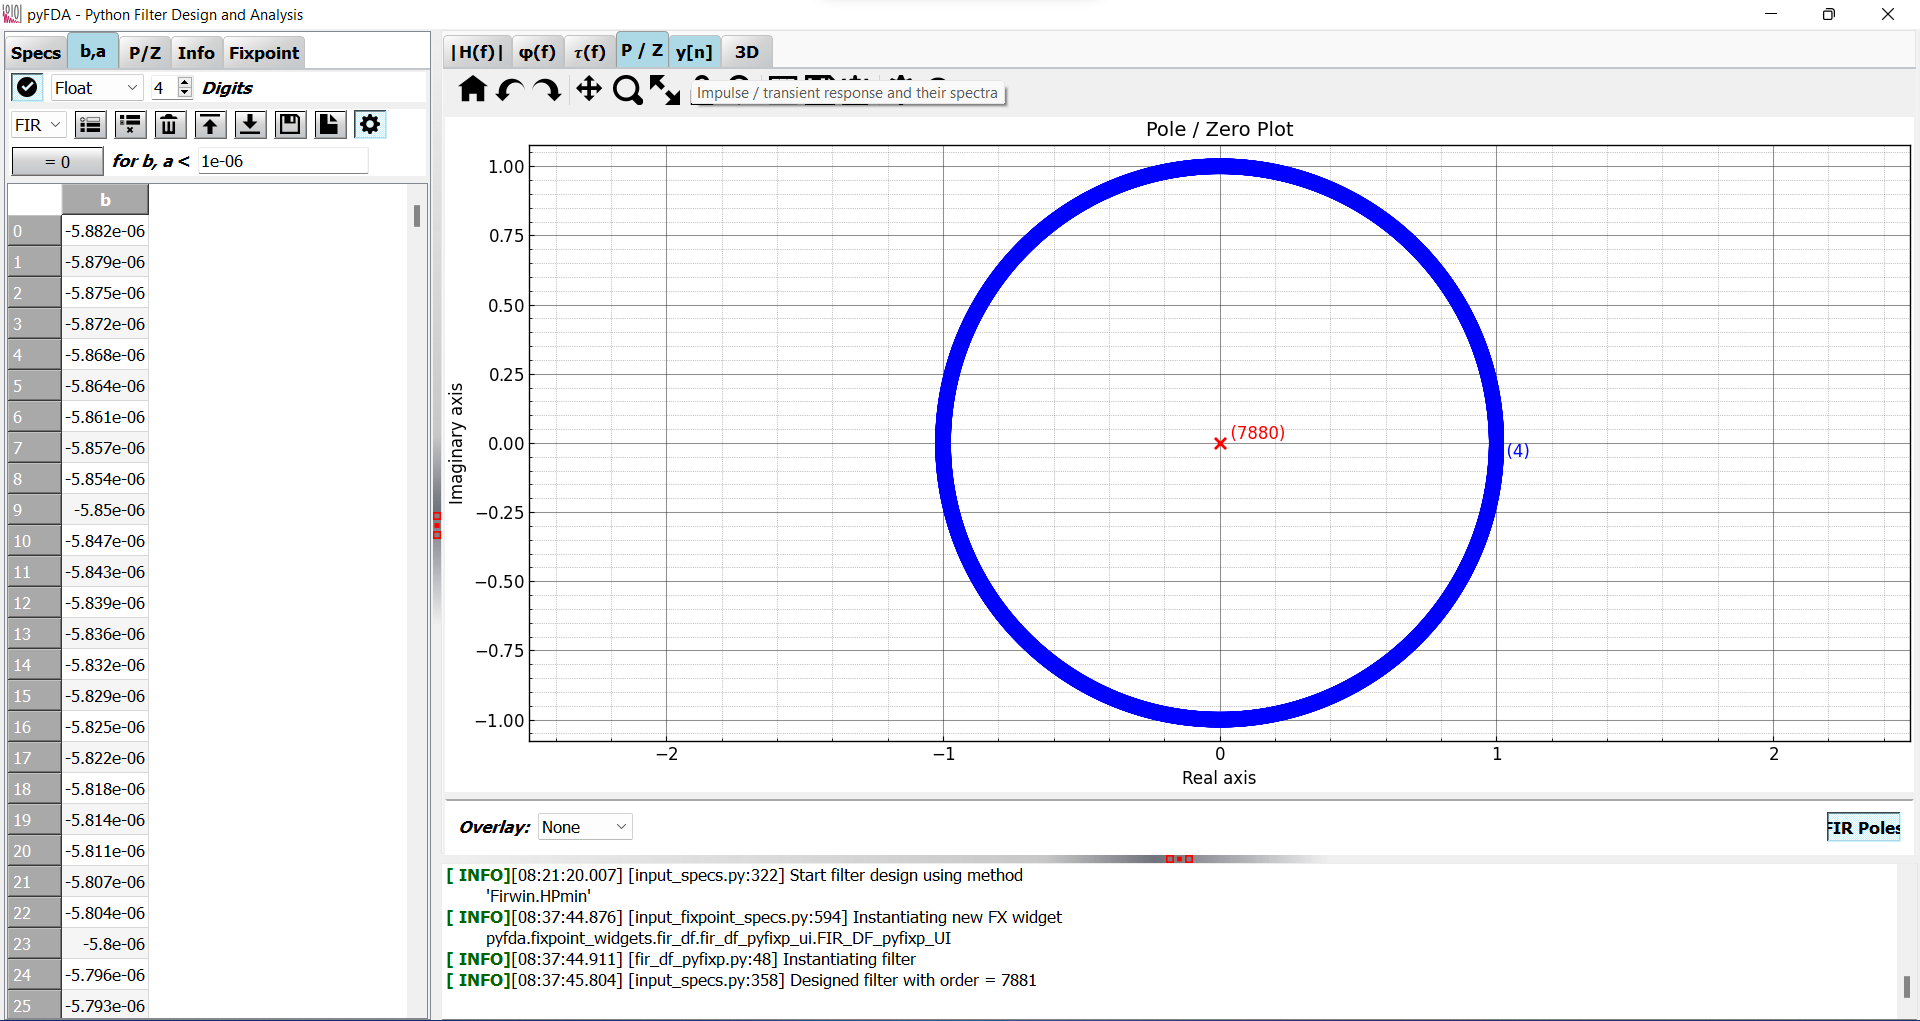

In [ ]:
#Coeficientes del Filtro IIR
with open('filtro FIR hight.csv') as csv_file:
    csv_reader = csv.reader(csv_file)
    filter_hight_FIR=[]
    for row in csv_reader:
        filter_hight_FIR.append(row)
b_hight_FIR=np.array(filter_hight_FIR[0]).T.astype(float)
b_hight_FIR

array([-5.88218137e-06, -5.87862544e-06, -5.87506828e-06, ...,
       -5.87506828e-06, -5.87862544e-06, -5.88218137e-06])

#FILTRANDOS LAS SEÑALES POR LOS 3 FILTROS FIR

####Filtrando la Señal de Notch

Text(0, 0.5, 'mV')

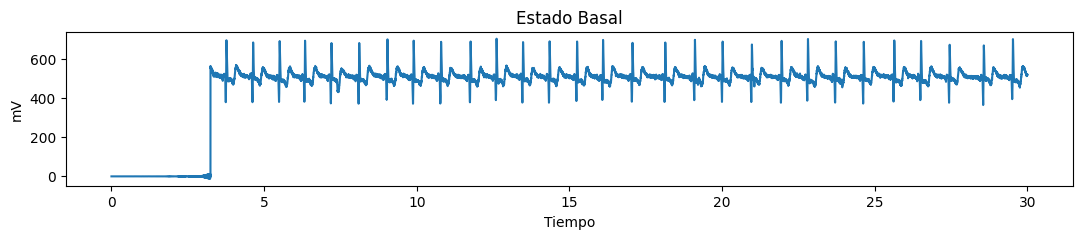

In [ ]:
y_noch_FIR = signal.lfilter(b_notch_FIR,np.array(1), base_total)
#Mostrando
n = np.arange(0,y_noch_FIR.shape[0])  # t = n*Ts ; Ventor de numeros de datos
t = n*Ts #VECTOR TIEMPO 
plt.figure(figsize=(13,2)) #Modificamos el tamaño de la gráfica
plt.plot(t, y_noch_FIR)
plt.title("Estado Basal")
plt.xlabel('Tiempo')
plt.ylabel('mV')

####Filtrando la Señal de 100 Hz

Text(0, 0.5, 'mV')

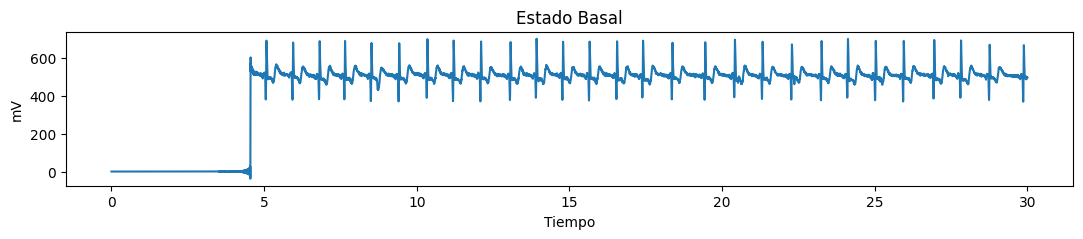

In [ ]:
y_100_FIR = signal.lfilter(b_100_FIR,np.array(1), y_noch_FIR)
#Mostrando
plt.figure(figsize=(13,2)) #Modificamos el tamaño de la gráfica
plt.plot(t, y_100_FIR)
plt.title("Estado Basal")
plt.xlabel('Tiempo')
plt.ylabel('mV')
#plt.xlim(5,8)


####Filtrando la Señal por un pasa altas

[4.99416886e-13 1.57527988e-12 2.59447272e-12 ... 5.11177481e+02
 5.10419235e+02 5.09667936e+02]


Text(0, 0.5, 'mV')

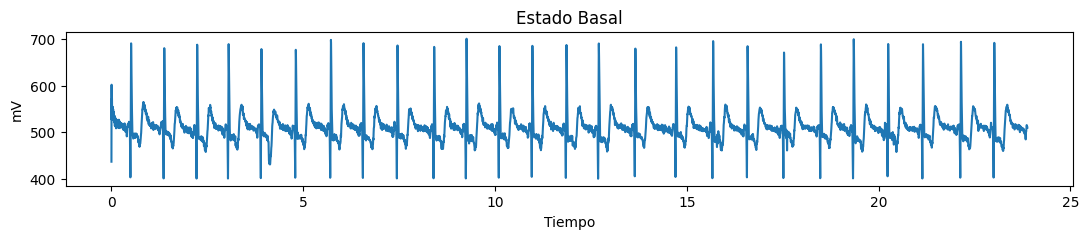

In [ ]:
y_hight_FIR = signal.lfilter(b_100_FIR,np.array(1), y_100_FIR)
print(y_hight_FIR)
#y_hight_FIR=y_hight_FIR[np.nonzero(y_hight_FIR)]
y_hight_FIR= [num for num in y_hight_FIR if 400 <= num <= 800]
y_hight_FIR=np.array(y_hight_FIR)
n = np.arange(0,y_hight_FIR.shape[0])  # t = n*Ts ; Ventor de numeros de datos
t = n*Ts #VECTOR TIEMPO 
#Mostrando
plt.figure(figsize=(13,2)) #Modificamos el tamaño de la gráfica
plt.plot(t, y_hight_FIR)
plt.title("Estado Basal")
plt.xlabel('Tiempo')
plt.ylabel('mV')
#plt.xlim(5,8)


#Graficar Su frecuencia Filtrada


(1024,)


Text(0, 0.5, '|X|')

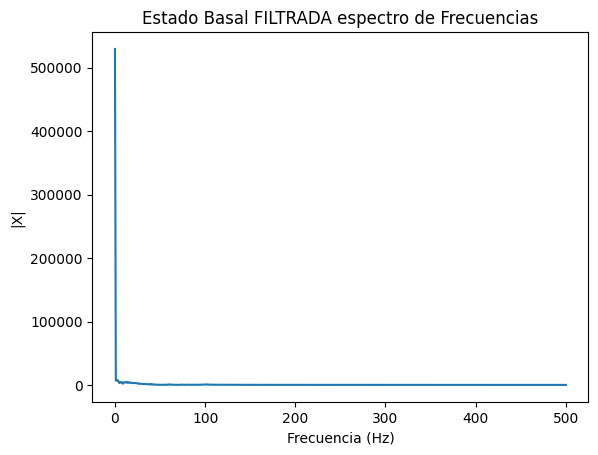

In [ ]:
N = 2**10 #Resolución
fs=1000
base_frec_filt_FIR = np.fft.fft(y_hight_FIR,N)
print(base_frec_filt_FIR.shape)
base_frec_filt_FIR= base_frec_filt_FIR[0:(N//2)]
#magnitud
base_frecm_filt_FIR = np.abs(base_frec_filt_FIR)
base_frecm_filt_FIR = np.round(base_frecm_filt_FIR,3)
#frecuencias
F = np.linspace(0, Fs/2, N//2)
#eje de tiempo en seg
t = n/Fs
plt.plot(F,base_frecm_filt_FIR)
plt.title("Estado Basal FILTRADA espectro de Frecuencias")
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('|X|')

En el Rango de Frecuencias ECG

(0.0, 9000.0)

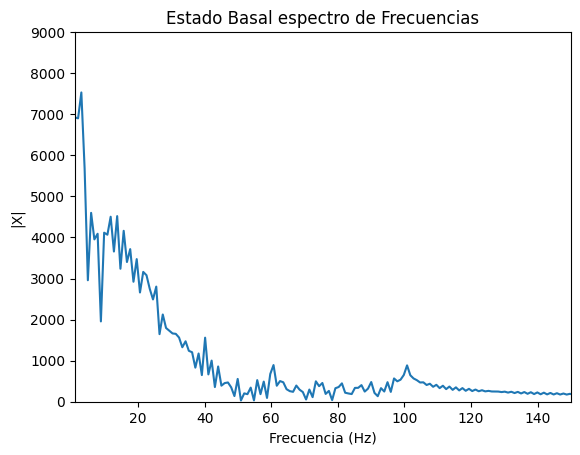

In [ ]:
plt.plot(F,base_frecm_filt_FIR)
plt.title("Estado Basal espectro de Frecuencias")
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('|X|')
plt.xlim(1,150)
plt.ylim(0,9000)

#Para Cada estado ECG FIR

Text(0, 0.5, 'mV')

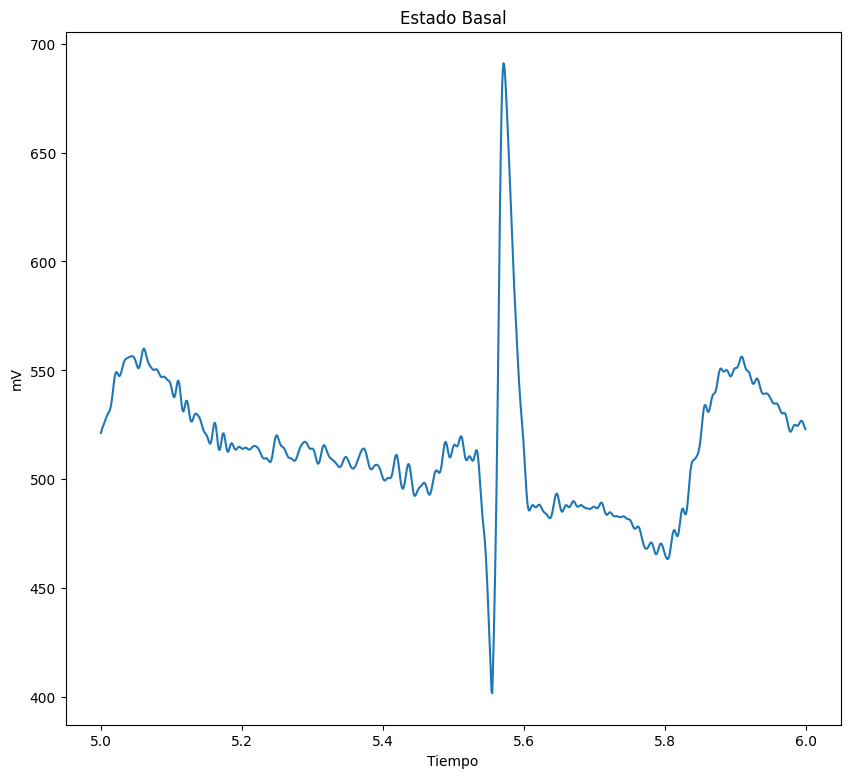

In [ ]:
plt.figure(figsize=(10,9)) #Modificamos el tamaño de la gráfica
plt.plot(t[5000:6000], y_hight_FIR[6000:7000])
plt.title("Estado Basal")
plt.xlabel('Tiempo')
plt.ylabel('mV')

## Visualizando estado de respiraicón


Text(0, 0.5, 'mV')

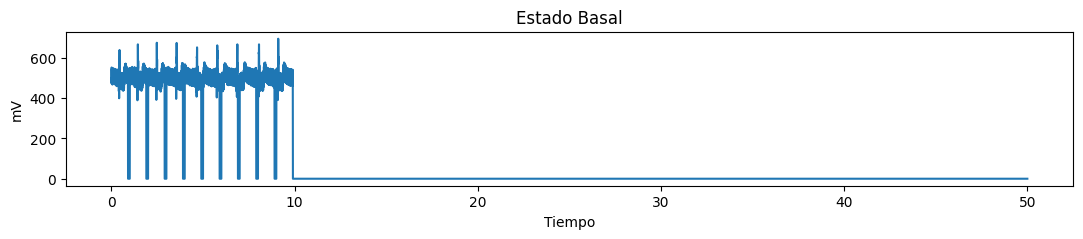

In [ ]:
#Mostrar datos en el tiempo
respiracion=np.reshape(respiracion,-1)
#Frecuencia de muestreo del dispositivo de adquisición
Fs = 1000 
Ts=1/Fs
n = np.arange(0,base_r.shape[0])  # t = n*Ts ; Ventor de numeros de datos
t = n*Ts #VECTOR TIEMPO 
plt.figure(figsize=(13,2)) #Modificamos el tamaño de la gráfica
plt.plot(t, respiracion)
plt.title("Estado Basal")
plt.xlabel('Tiempo')
plt.ylabel('mV')

### Cortando la señal

Text(0, 0.5, 'mV')

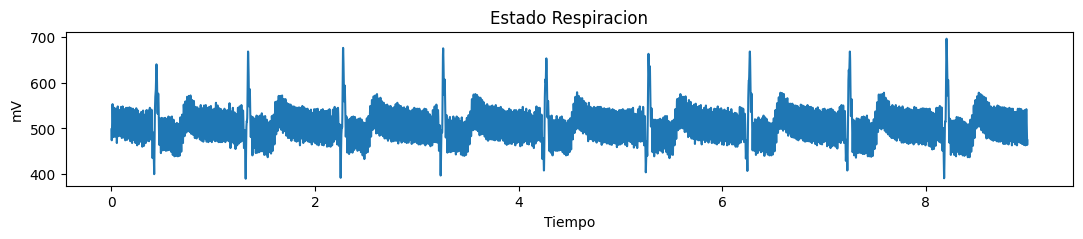

In [ ]:
#DEBIDO A QUE A PARTIR DE SON 3000 DATOS DE LOS 5000
#=base_r[0:30000]
respiracion_total=respiracion[np.nonzero(respiracion)]

Ts=1/1000
n = np.arange(0,respiracion_total.shape[0])  # t = n*Ts ; Ventor de numeros de datos
t = n*Ts #VECTOR TIEMPO 
plt.figure(figsize=(13,2)) #Modificamos el tamaño de la gráfica
plt.plot(t, respiracion_total)
plt.title("Estado Respiracion")
plt.xlabel('Tiempo')
plt.ylabel('mV')

### Aplicando los filtros

Filtro Notch

Text(0, 0.5, 'mV')

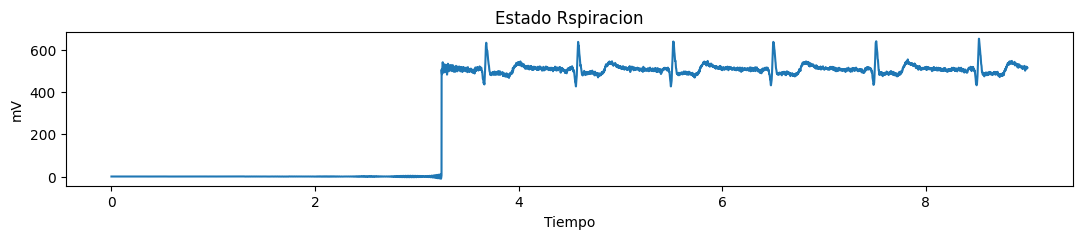

In [ ]:
y_noch_FIR = signal.lfilter(b_notch_FIR,np.array(1), respiracion_total)
#Mostrando
plt.figure(figsize=(13,2)) #Modificamos el tamaño de la gráfica
plt.plot(t, y_noch_FIR)
plt.title("Estado Rspiracion")
plt.xlabel('Tiempo')
plt.ylabel('mV')

Filtro pasabajas

Text(0, 0.5, 'mV')

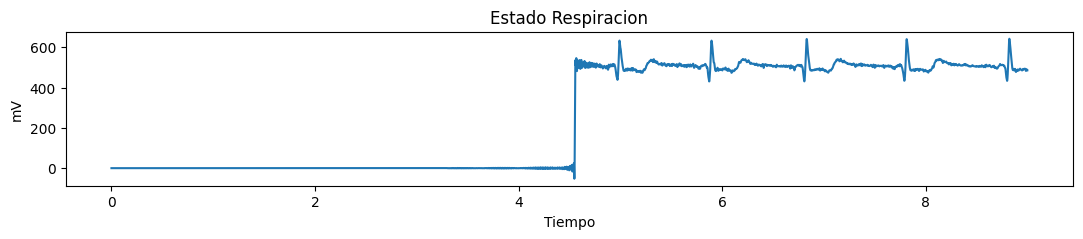

In [ ]:
y_100_FIR = signal.lfilter(b_100_FIR,np.array(1), y_noch_FIR)
#Mostrando
plt.figure(figsize=(13,2)) #Modificamos el tamaño de la gráfica
plt.plot(t, y_100_FIR)
plt.title("Estado Respiracion")
plt.xlabel('Tiempo')
plt.ylabel('mV')
#plt.xlim(5,8)

Filtro pasaaltas

Text(0, 0.5, 'mV')

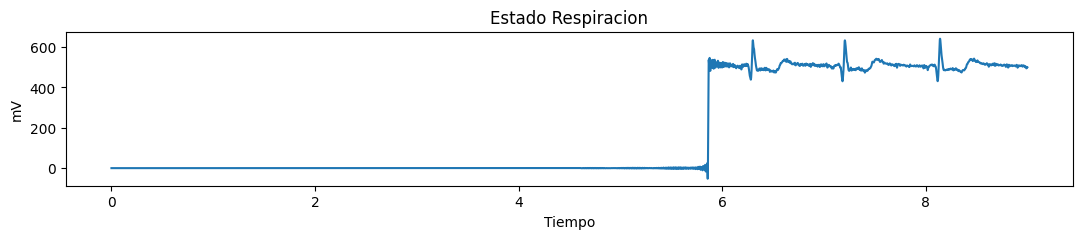

In [ ]:
y_hight_FIR = signal.lfilter(b_100_FIR,np.array(1), y_100_FIR)
#y_hight=y_hight[100:-1]
n = np.arange(0,y_hight_FIR.shape[0])  # t = n*Ts ; Ventor de numeros de datos
t = n*Ts #VECTOR TIEMPO 
#Mostrando
plt.figure(figsize=(13,2)) #Modificamos el tamaño de la gráfica
plt.plot(t, y_hight_FIR)
plt.title("Estado Respiracion")
plt.xlabel('Tiempo')
plt.ylabel('mV')
#plt.xlim(5,8)


Text(0, 0.5, 'mV')

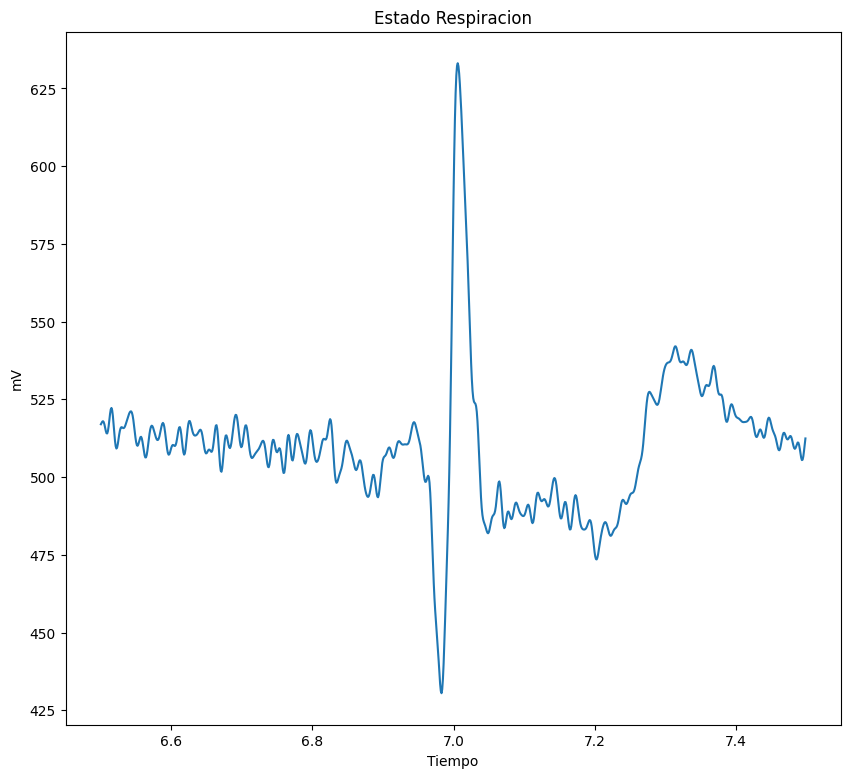

In [ ]:
plt.figure(figsize=(10,9)) #Modificamos el tamaño de la gráfica
plt.plot(t[6500:7500], y_hight_FIR[6700:7700])
plt.title("Estado Respiracion")
plt.xlabel('Tiempo')
plt.ylabel('mV')

## Visualizando la señaml de post Ejercicio

Text(0, 0.5, 'mV')

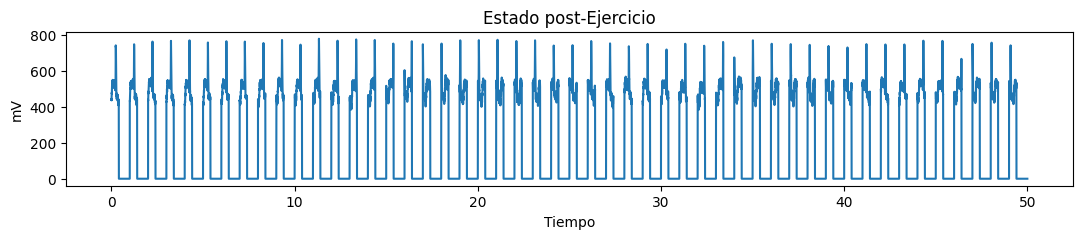

In [ ]:
#Mostrar datos en el tiempo
Ejer=np.reshape(post_ejercicio,-1)
#Frecuencia de muestreo del dispositivo de adquisición
Fs = 1000 
Ts=1/Fs
n = np.arange(0,Ejer.shape[0])  # t = n*Ts ; Ventor de numeros de datos
t = n*Ts #VECTOR TIEMPO 
plt.figure(figsize=(13,2)) #Modificamos el tamaño de la gráfica
plt.plot(t, Ejer)
plt.title("Estado post-Ejercicio")
plt.xlabel('Tiempo')
plt.ylabel('mV')

### Cortando señal

Text(0, 0.5, 'mV')

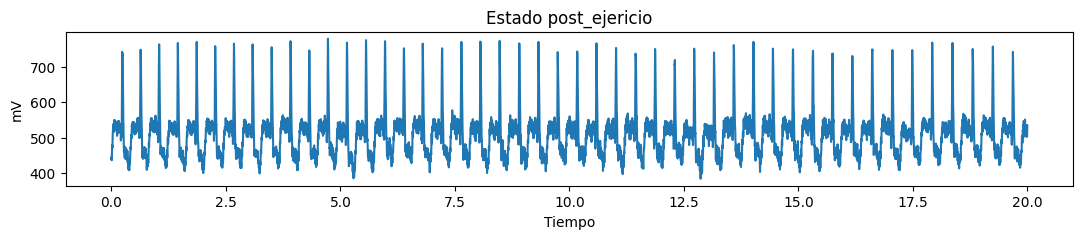

In [ ]:
#DEBIDO A QUE A PARTIR DE SON 3000 DATOS DE LOS 5000
#=base_r[0:30000]
ejer_total=Ejer[np.nonzero(Ejer)]

Ts=1/1000
n = np.arange(0,ejer_total.shape[0])  # t = n*Ts ; Ventor de numeros de datos
t = n*Ts #VECTOR TIEMPO 
plt.figure(figsize=(13,2)) #Modificamos el tamaño de la gráfica
plt.plot(t, ejer_total)
plt.title("Estado post_ejericio")
plt.xlabel('Tiempo')
plt.ylabel('mV')

### Aplicando Filtros

Filtro Notch

Text(0, 0.5, 'mV')

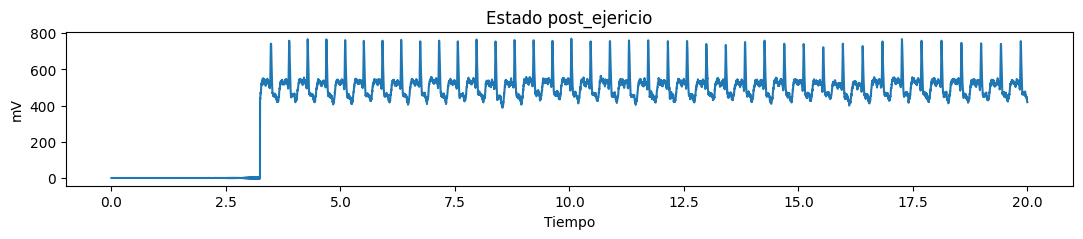

In [ ]:
y_noch_FIR = signal.lfilter(b_notch_FIR,np.array(1), ejer_total)
#Mostrando
plt.figure(figsize=(13,2)) #Modificamos el tamaño de la gráfica
plt.plot(t, y_noch_FIR)
plt.title("Estado post_ejericio")
plt.xlabel('Tiempo')
plt.ylabel('mV')

Filtro pasa bajas

Text(0, 0.5, 'mV')

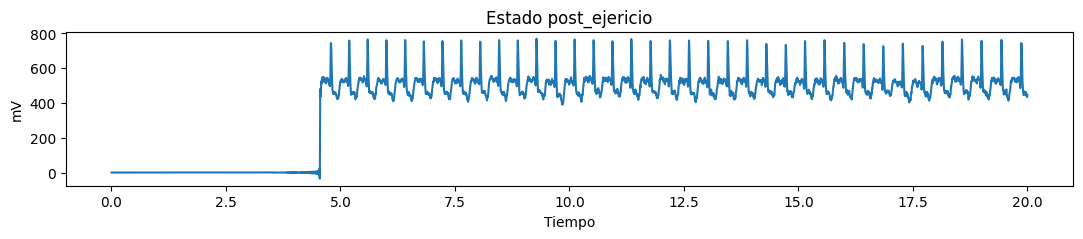

In [ ]:
y_100_FIR = signal.lfilter(b_100_FIR,np.array(1), y_noch_FIR)
#Mostrando
plt.figure(figsize=(13,2)) #Modificamos el tamaño de la gráfica
plt.plot(t, y_100_FIR)
plt.title("Estado post_ejericio")
plt.xlabel('Tiempo')
plt.ylabel('mV')
#plt.xlim(5,8)

Filtros pasaaltas

Text(0, 0.5, 'mV')

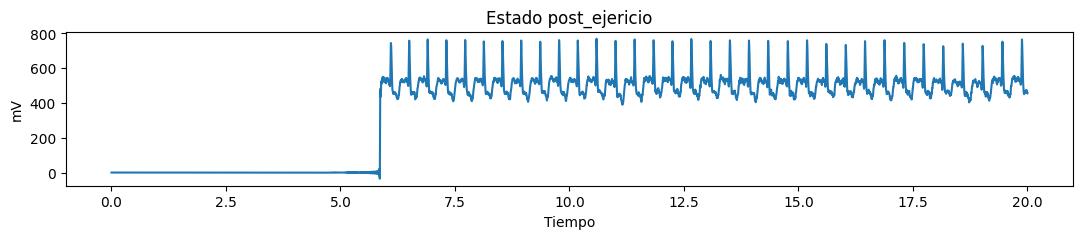

In [ ]:
y_hight_FIR = signal.lfilter(b_100_FIR,np.array(1), y_100_FIR)
#y_hight=y_hight[100:-1]
n = np.arange(0,y_hight_FIR.shape[0])  # t = n*Ts ; Ventor de numeros de datos
t = n*Ts #VECTOR TIEMPO 
#Mostrando
plt.figure(figsize=(13,2)) #Modificamos el tamaño de la gráfica
plt.plot(t, y_hight_FIR)
plt.title("Estado post_ejericio")
plt.xlabel('Tiempo')
plt.ylabel('mV')
#plt.xlim(5,8)


Text(0, 0.5, 'mV')

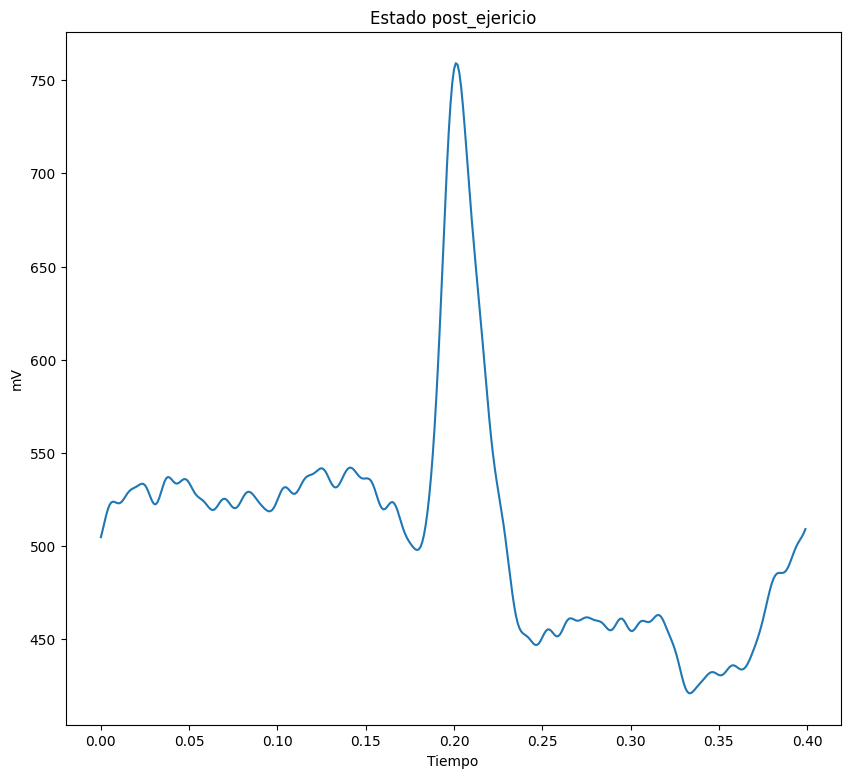

In [ ]:
plt.figure(figsize=(10,9)) #Modificamos el tamaño de la gráfica
plt.plot(t[0:400], y_hight_FIR[6300:6700])
plt.title("Estado post_ejericio")
plt.xlabel('Tiempo')
plt.ylabel('mV')